## Using multiple strides in treadmill-acquired gait data for Multiple Sclerosis prediction 
### Extracting and low dimensional vizualizations for the last layer features from the best subject generalization model (Resnet)
* This analysis is only done on regress-N data and best subject gen model (for the regress-N data)
* Best subject gen model for regress-N data is Resnet 

Reference: https://towardsdatascience.com/visualizing-feature-vectors-embeddings-using-pca-and-t-sne-ef157cea3a42



In [2]:
import sys
sys.path.append(r'D:\gait') #Because I am reading pickle file which is at a different folder

In [56]:
import torch
import torch.nn as nn
import numpy as np
import pickle
from torchinfo import summary
from utils.utils_lstm import FixRandomSeed, set_random_seed, MyCheckpoint
# %matplotlib widget
import matplotlib.pyplot as plt

import pandas as pd
from sklearn import decomposition, manifold
from mpl_toolkits import mplot3d
import matplotlib.gridspec as gridspec
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import matplotlib as mpl
import seaborn as sns
from IPython import display
import json 

from utils.package_imports import *
from utils.LSTM import LSTM
from utils.GRU import GRU
from utils.RNN import RNN
from utils.TCN_model import TCN
from utils.CNN1D import CNN1D
from utils.utils_lstm import torch_StandardScaler
from utils.MSResNet import MSResNet
from utils.ResNet import ResNet

In [139]:
#Use BestResNetSubject12021_05_31-23_24_55_097887
#Pretrained best Subject gen Resnet model and data path
path = "D:\\gait\\results\\subject_generalize_lstm\\5strides\\all\\ResNet\\regressN\\[person_83]BestResNetSubject12021_05_31-23_24_55_097887\\"

fold1_model_path = "train_end_params.pt"
fold2_model_path = "train_end_140732471550384params.pt"
fold3_model_path = "train_end_140732461362848params.pt"
fold4_model_path = "train_end_140732461040696params.pt"
fold5_model_path = "train_end_140732461428600params.pt"

#Fold 1 model: train_end_params.pt
#Fold 2 model: train_end_140732471550384params.pt
#Fold 3 model: train_end_140732461362848params.pt 
#Fold 4 model: train_end_140732461040696params.pt
#Fold 5 model: train_end_140732461428600params.pt

In [140]:
def load_train_test_X_Y_per_fold(fold_to_analyse = 1):
    train_X = pd.read_csv(path + "indices_X_train_fold_" + str(fold_to_analyse) + ".csv", index_col = 0)
    train_Y = pd.read_csv(path + "indices_Y1_train_fold_" + str(fold_to_analyse) + ".csv", index_col = 0)
    test_X = pd.read_csv(path + "indices_X_test_fold_" + str(fold_to_analyse) + ".csv", index_col = 0)
    test_Y = pd.read_csv(path + "indices_Y1_test_fold_" + str(fold_to_analyse) + ".csv", index_col = 0)
    return train_X, train_Y, test_X, test_Y

In [141]:
#This needs to contain all optimizers that will be used so they can be properly imported
optims = {
    'torch.optim.Adam': torch.optim.Adam,
    'torch.optim.SGD': torch.optim.SGD,
    'torch.optim.Adagrad': torch.optim.Adagrad,
    'torch.optim.AdamW': torch.optim.AdamW,
    'torch.optim.RMSprop': torch.optim.RMSprop,
    "torch.optim.Adamax": torch.optim.Adamax
}

In [142]:
#To convert the saved pretrained model to a skorch model 
def create_model(model, device, bidirectional = False, lpath = None):
    '''
    Creates Skorch LSTM model
    Arguments:
        bidirectional: Whether the lstm is bidirectional
    Returns:
        Created skorch network
    '''
    #device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    #model = LSTM(input_size, hidden_size1, num_layers1, hidden_size2, num_layers2, num_classes, dropout, bidirectional, bidirectional, pre_out, single_lstm, linear_size).to(device)
    #set_random_seed(seed)
    net = NeuralNetClassifier(
        model,
        max_epochs = 10,
        lr = .01,
        criterion=nn.CrossEntropyLoss,
        optimizer=torch.optim.Adam,
        device = device,
        iterator_train__shuffle=True,
        batch_size=100,
        train_split = dataset.CVSplit(5, random_state = 0),
        callbacks=[EarlyStopping(patience = 10, lower_is_better = True, threshold=0.0001),
            (FixRandomSeed()),
        #('lr_scheduler', LRScheduler(policy=torch.optim.lr_scheduler.StepLR, step_size = 500)),
            (EpochScoring(scoring=accuracy_score, lower_is_better = False, on_train = True, name = "train_acc")),
            ((MyCheckpoint(f_params='params.pt', f_optimizer='optimizer.pt', f_criterion='criterion.pt', f_history='history.json', f_pickle=None, fn_prefix='train_end_', dirname= lpath)))] #add path
        #callbacks=[EarlyStopping(patience = 100, lower_is_better = True, threshold=0.0001),
        #(EpochScoring(scoring=accuracy_score, lower_is_better = False, on_train = True, name = "train_acc"))]
    )
    return net

In [143]:
#Scaling data between 0 and 1
def min_max_scale(data):
    data = data.reshape(-1, 1)
    scaler = MinMaxScaler()
    return scaler.fit_transform(data)

In [144]:
#Defining the device 
use_cuda = torch.cuda.is_available() #use_cuda is True if cuda is available 
set_random_seed(0) #Setting a fixed random seed for reproducibility 
device = torch.device("cuda" if use_cuda else "cpu")

In [145]:
#Read the config file for the best hyperparameters 
#Load config
with open(path+"config.json") as f: 
    config_data = f.read()

config = json.loads(config_data)
isSubject = True
subject_params = {}
vars_ = {}

#Fill up the hyperparameters dictionary
for key, value in config.items():
    if "param" in key:
        pkey = key.replace("param", "net__")
        if "net__optimizer" == pkey:
            op = []
            for optim_string in value:
                op.append(optims[optim_string])
            subject_params[pkey] = op
        elif "net__criterion__weight" == pkey:
            weights = []
            for weight_list in value:
                weights.append(torch.FloatTensor(weight_list))
            subject_params[pkey] = weights
        else:
                subject_params[pkey] = value
    else:
        vars_[key] = value

In [146]:
#Defining the torch model based on best config hyperparameters for Resnet (best model)
torch_model = None
if vars_["model"] == "LSTM":
    input_size = subject_params["net__module__in_chans"][0]
    num_classes = subject_params["net__module__num_classes"][0]
    pre_out = 1
    torch_model = LSTM(input_size, hidden_size1, num_layers1, hidden_size2, num_layers2, num_classes, dropout_, bidirectional, bidirectional, pre_out, single_layer, linear_size, device, use_layernorm).to(device)
if vars_["model"] == "GRU":
    input_size = subject_params["net__module__in_chans"][0]
    num_classes = subject_params["net__module__num_classes"][0]
    pre_out = 1
    torch_model = GRU(input_size, hidden_size1, num_layers1, hidden_size2, num_layers2, num_classes, dropout_, bidirectional, bidirectional, pre_out, single_layer, linear_size, device, use_layernorm).to(device)
if vars_["model"] == "RNN":
    input_size = subject_params["net__module__in_chans"][0]
    num_classes = subject_params["net__module__num_classes"][0]
    pre_out = 1
    torch_model = RNN(input_size, hidden_size1, num_layers1, hidden_size2, num_layers2, num_classes, dropout_, bidirectional, bidirectional, pre_out, single_layer, linear_size, device, use_layernorm).to(device)
if vars_["model"] == "TCN":
    in_chans = subject_params["net__module__in_chans"][0]
    out_chans = 2 
    num_channels = [20, 20]
    kernel_size = 3
    dropout = .3
    torch_model = TCN(in_chans, out_chans, num_channels, kernel_size, dropout).to(device)
if vars_["model"] == "CNN":
    in_chans = subject_params["net__module__in_chans"][0]
    out_chans =  [64]
    kernel_size = [2]
    stride = [1]
    dilation = [1]
    groups = [1]
    batch_norm = [True]
    dropout = [0.3]
    maxpool = [True]
    maxpool_kernel_size = [2]
    dense_out_sizes = [10]
    dense_pool = True
    dense_pool_kernel_size = 2
    dense_dropout = [0]
    global_average_pool = True
    num_classes = subject_params["net__module__num_classes"][0]
    time_steps = strides_per_sequence
    position_encoding = True
    torch_model = CNN1D(in_chans, out_chans, kernel_size, stride, dilation, groups, batch_norm, dropout, maxpool, maxpool_kernel_size, dense_out_sizes, dense_pool, dense_pool_kernel_size, dense_dropout, global_average_pool, num_classes, time_steps, position_encoding).to(device)
if vars_["model"] == "MSResNet":
    in_chans = subject_params["net__module__in_chans"][0]
    layers = [1, 1, 1, 1]
    num_classes = subject_params["net__module__num_classes"][0]
    torch_model = MSResNet(in_chans, layers, num_classes)

if vars_["model"] == "ResNet":
    in_chans =  subject_params["net__module__in_chans"][0]
    initial_conv_layer = subject_params["net__module__initial_conv_layer"][0]
    block_name = subject_params["net__module__block_name"][0]
    layers = subject_params["net__module__layers"][0]
    kernel_size_conv1 =  subject_params["net__module__kernel_size_conv1"][0]
    kernel_size_conv2 = subject_params["net__module__kernel_size_conv2"][0]
    kernel_size_conv3 = subject_params["net__module__kernel_size_conv3"][0]
    stride_layer64 = subject_params["net__module__stride_layer64"][0]
    stride_layer128 = subject_params["net__module__stride_layer128"][0]
    stride_layer256 = subject_params["net__module__stride_layer256"][0]
    stride_layer512 = subject_params["net__module__stride_layer512"][0]
    position_encoding = subject_params["net__module__position_encoding"][0]
    num_classes = subject_params["net__module__num_classes"][0]
    torch_model = ResNet(in_chans, initial_conv_layer, block_name, layers, kernel_size_conv1, kernel_size_conv2, kernel_size_conv3, stride_layer64, stride_layer128, stride_layer256, stride_layer512, position_encoding, num_classes)

In [147]:
#Converting the torch model to skorch model 
skorch_model = create_model(torch_model, device)

### For fold 1

In [158]:
#Loading the fold 1 pretrained model
skorch_model.initialize() # This is important!
skorch_model.load_params(f_params = path + fold1_model_path)  

#Loading the fold 1 training and test data
fold_to_analyse = 1
train_X, train_Y, test_X, test_Y = load_train_test_X_Y_per_fold(fold_to_analyse)

#Keeping a separate column for the PIDs
train_Y.reset_index(inplace= True)
train_Y.columns = ['PID', 'Label']

test_Y.reset_index(inplace= True)
test_Y.columns = ['PID', 'Label']

setting random seed to:  0
Re-initializing optimizer.


In [159]:
#Processing the read train/test X to 3D tensor of batch_size*time_steps(5)*features(21)
train_X_, test_X_ = [], []

for idx in range(len(train_X)):
    new_data_sample = torch.tensor(train_X.iloc[idx].apply(lambda x : [float(x) for x in x.replace("tensor(", "").replace(")", "").replace("[", "").replace ("]", "").split(",")])).reshape((5, 21))
    train_X_.append(new_data_sample)

for idx in range(len(test_X)):
    new_data_sample = torch.tensor(test_X.iloc[idx].apply(lambda x : [float(x) for x in x.replace("tensor(", "").replace(")", "").replace("[", "").replace ("]", "").split(",")])).reshape((5, 21))
    test_X_.append(new_data_sample)
    
print ('No. of samples in training set for fold', fold_to_analyse, ':', len(train_X_))
print ('No. of samples in testing set for fold', fold_to_analyse, ':', len(test_X_))

#Converting list of tensors to 3D tensor 
train_X_ = torch.stack(train_X_)
test_X_ = torch.stack(test_X_)

print (train_X_.shape, test_X_.shape)

No. of samples in training set for fold 1 : 1141
No. of samples in testing set for fold 1 : 295
torch.Size([1141, 5, 21]) torch.Size([295, 5, 21])


In [160]:
#last layer features for the train set of this fold
skorch_model.module_.forward(train_X_)
last_layer_features_train = skorch_model.module_.lastLayerFeatures
print ('Last layer features for training:', last_layer_features_train.shape)

#Last layer features for the test set of this fold 
skorch_model.module_.forward(test_X_)
last_layer_features_test = skorch_model.module_.lastLayerFeatures
print ('Last layer features for testing:',last_layer_features_test.shape)

Last layer features for training: torch.Size([1141, 2048])
Last layer features for testing: torch.Size([295, 2048])


In [161]:
last_layer_features_train = last_layer_features_train.detach().numpy()
last_layer_features_test = last_layer_features_test.detach().numpy()

train_df = pd.DataFrame(last_layer_features_train)
train_df = pd.concat((train_df, train_Y), axis = 1) #Appending PID and label
train_df['marker'] = 'train' #To mark these data as training set data 

test_df = pd.DataFrame(last_layer_features_test)
test_df = pd.concat((test_df, test_Y), axis = 1) #Appending PID and label
test_df['marker'] = 'test' #To mark these data as testing set data 

#Combining all data last layer features, PID, label along with marker for train/test data
df = pd.concat((train_df, test_df), ignore_index=True)
df['color'] = 'r' #Initially all red
df['color'][df[df['Label']==0].index] = 'g' #Green for controls 

In [162]:
df.head()

0    1    2    3    4    5    6    7    8    9  ...  2042  2043  2044  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   

   2045  2046  2047   PID  Label  marker  color  
0   0.0   0.0   0.0  1527      1   train      r  
1   0.0   0.0   0.0   945      0   train      g  
2   0.0   0.0   0.0   784      0   train      g  
3   0.0   0.0   0.0  3083      1   train      r  
4   0.0   0.0   0.0  1107      1   train      r  

[5 rows x 2052 columns]

In [83]:
df = test_df
df['color'] = 'r' #Initially all red
df['color'][df[df['Label']==0].index] = 'g' #Green for controls 

In [163]:
last_layer_features = df[list(range(last_layer_features_test.shape[1]))]
print ((last_layer_features<0).sum().sum())
data_to_reduce = last_layer_features
print ('Dimesions for original last layer test set features: ', data_to_reduce.shape)
data_to_reduce_normalized = StandardScaler().fit_transform(data_to_reduce)

normalize = False #Not normalizing last layer features before feeding to t-SNE 
test = False

0
Dimesions for original last layer test set features:  (1436, 2048)


In [77]:
def tsne_plot(perp = 30):
    #Non linear methods: t-SNE
    #t-SNE 
    tsne = manifold.TSNE(n_components=2, init='random', random_state=0, perplexity=perp, n_iter = 20000) #2D tsne 

    if normalize:
        tsne_2D = tsne.fit_transform(data_to_reduce_normalized)
    else:
        tsne_2D = tsne.fit_transform(data_to_reduce)

    #Normalizing the t-SNE values after computation 
    tsne_2D_normalized = np.concatenate((min_max_scale(tsne_2D[:, 0]), min_max_scale(tsne_2D[:, 1])), axis = 1)

    #However, if you use the same data and perplexity, you can compare the 
    #Kullback-Leibler divergences that t-SNE reports. It is perfectly fine to 
    #run t-SNE ten times, and select the solution with the lowest KL divergence.
    print ('KL divergence for t-SNE 2D = ', tsne.kl_divergence_, 'with perplexity = ', perp)


    # tsne = manifold.TSNE(n_components=3, init='random', random_state=0, perplexity=30) #3D tsne 
    # tsne_3D = tsne.fit_transform(data_to_reduce)
    
    #2D t-SNE Scatter plot 
    f = plt.figure(figsize=(9, 9))
    ax = f.add_subplot(1, 1, 1)
    ax.scatter(tsne_2D_normalized[:, 0], tsne_2D_normalized[:, 1], c = df['color'], alpha =0.3)
    p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc='green')
    # p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc='cyan')
    p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc='blue')
    p4 = plt.Rectangle((0, 0), 0.1, 0.1, fc='red')
    ax.legend((p1, p4), ('HOA','PwMS'), loc='best', fontsize = 20);
    ax.grid(False)
    ax.set_xlabel('Axis 1')
    ax.set_ylabel('Axis 2')
    ax.set_title("tsne_2D: Original Labels")
    plt.savefig('D:\\gait\\results\\SubjectGen_LowDimViz\\fold' + str(fold_to_analyse) + '\\tsne_2D_original_' + str(perp) + str(normalize) + 'test_' + str(test) + '.png',dpi = 200)
    plt.close()
    
    tsne2D_added_colors = pd.DataFrame(tsne_2D_normalized, df['color'])
    tsne2D_added_colors.columns = ['tsnex', 'tsney']
    x_green = tsne2D_added_colors.loc[tsne2D_added_colors.index=='g']['tsnex'].values
    y_green = tsne2D_added_colors.loc[tsne2D_added_colors.index=='g']['tsney'].values
    x_red =tsne2D_added_colors.loc[tsne2D_added_colors.index=='r']['tsnex'].values
    y_red = tsne2D_added_colors.loc[tsne2D_added_colors.index=='r']['tsney'].values

    #2D t-SNE scatter plot with joint and marginal distributions 
    ###Plotting with the distributions
    mpl.rcParams['axes.spines.top'] = True
    mpl.rcParams['axes.spines.right'] = True
    plt.rcParams['font.size'] = 15
    a = 0.2
    zo=0
    l=12
    p = sns.JointGrid(x = x_red, y = y_red, size = 7)
    p.x = list( x_red)
    p.y = list( y_red)
    p.plot_joint(plt.scatter, c="r", alpha = a)
    p.plot_marginals(sns.distplot, color='r', axlabel=[])
    p.plot_joint(sns.kdeplot, zorder=zo, n_levels=l, cmap="Reds")
#     plt.grid()
    p.x = list( x_green)
    p.y = list( y_green)
    p.plot_joint(plt.scatter, c="g", alpha = a)
    p.plot_marginals(sns.distplot, color='g', axlabel=[])
    p.plot_joint(sns.kdeplot, zorder=zo, n_levels=l, cmap="Greens")
#     plt.grid()
    p.set_axis_labels(xlabel='t-SNE Dimension 1', ylabel='t-SNE Dimension 2')
    # p.ax_joint.set_xticklabels([])
    # p.ax_joint.set_yticklabels([])
    # p.ax_marg_x.legend_.remove()
    p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc= 'green')
    # p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc='blue')
    p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc='red')
    plt.legend((p1,p3), ('HOA','PwMS'), loc='best', fontsize = 15)
    # plt.legend((p1, p2, p3), ('Low', 'Medium', 'High'), loc='best',prop={'size':12});
    # plt.title('Trial W', fontsize = 14)
    plt.xlabel('x-axis', fontsize = 15)
    plt.ylabel('y-axis', fontsize = 15)
#     plt.grid(linestyle='--')
    plt.tight_layout()
    plt.savefig('D:\\gait\\results\\SubjectGen_LowDimViz\\fold' + str(fold_to_analyse) + '\\tsne_2D_original_distributions_' + str(perp) + str(normalize)+ 'test_' + str(test) + '.png', dpi = 300)


## t-SNE

KL divergence for t-SNE 2D =  0.29954659938812256 with perplexity =  30
KL divergence for t-SNE 2D =  0.25731006264686584 with perplexity =  50
KL divergence for t-SNE 2D =  0.12548430263996124 with perplexity =  70
KL divergence for t-SNE 2D =  0.07919048517942429 with perplexity =  100


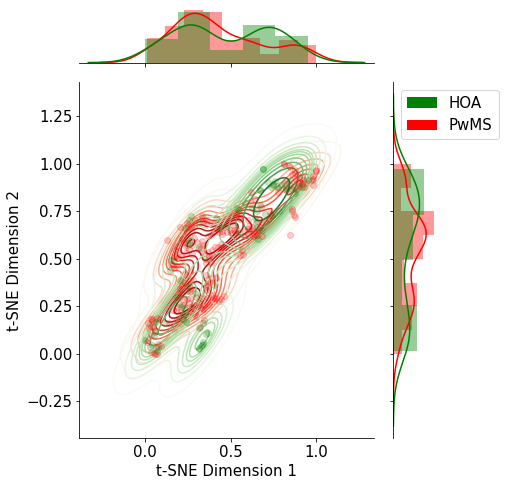

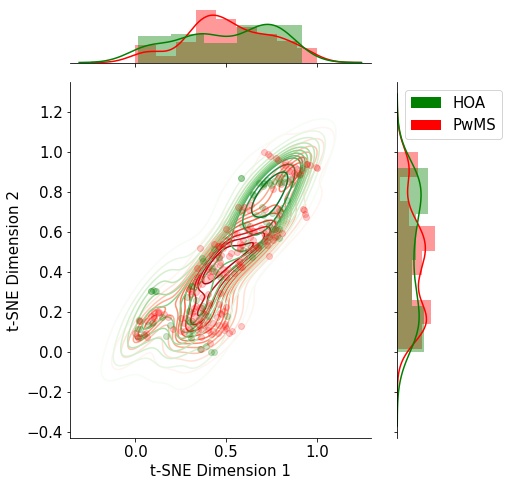

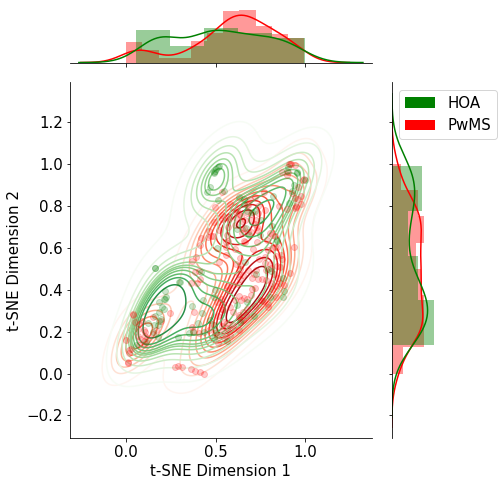

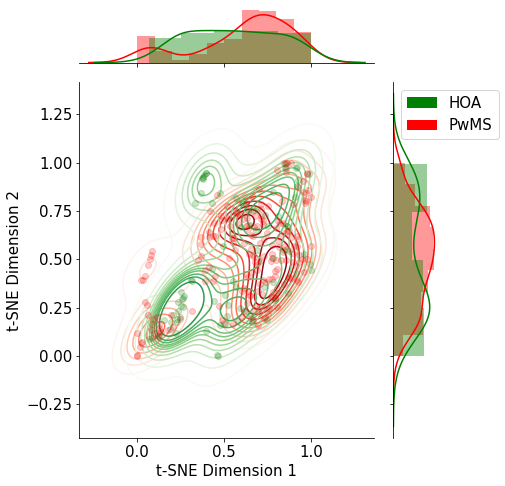

In [316]:
for p in [30, 50, 70, 100]:
    tsne_plot(p)

## 3D t-SNE

In [85]:
#3D t-SNE 
#Non linear methods: t-SNE
#t-SNE 
def tsne3D(perp = 30):
    tsne = manifold.TSNE(n_components=3, init='random', random_state=0, perplexity=perp, n_iter = 20000) #2D tsne 
    tsne_3D = tsne.fit_transform(data_to_reduce)

    #Normalizing the t-SNE values after computation 
    tsne_3D_normalized = np.concatenate((min_max_scale(tsne_3D[:, 0]), min_max_scale(tsne_3D[:, 1]), min_max_scale(tsne_3D[:, 2])), axis = 1)

    #However, if you use the same data and perplexity, you can compare the 
    #Kullback-Leibler divergences that t-SNE reports. It is perfectly fine to 
    #run t-SNE ten times, and select the solution with the lowest KL divergence.
    print ('KL divergence for t-SNE 3D = ', tsne.kl_divergence_, 'with perplexity = ', perp)

    f = plt.figure(figsize=(9, 9))
    ax = f.add_subplot(1, 1, 1)
    ax = plt.axes(projection='3d')
    ax.scatter3D(tsne_3D_normalized[:, 0], tsne_3D_normalized[:, 1], tsne_3D_normalized[:, 2], c = df['color'], alpha =0.3)
    p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc='green')
    # p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc='cyan')
    # p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc='blue')
    p4 = plt.Rectangle((0, 0), 0.1, 0.1, fc='red')
    ax.legend((p1, p4), ('HOA','PwMS'), loc='best', fontsize = 20);
    ax.grid(False)
    ax.set_xlabel('Axis 1')
    ax.set_ylabel('Axis 2')
    ax.set_title("tSNE-3D: Original Labels")
    plt.savefig('D:\\gait\\results\\SubjectGen_LowDimViz\\fold' + str(fold_to_analyse) + '\\tsne3D_original_perp'+str(perp)+ 'test_' + str(test) +'.png',dpi = 200)

KL divergence for t-SNE 3D =  0.2377023845911026 with perplexity =  10
KL divergence for t-SNE 3D =  0.1831609308719635 with perplexity =  20


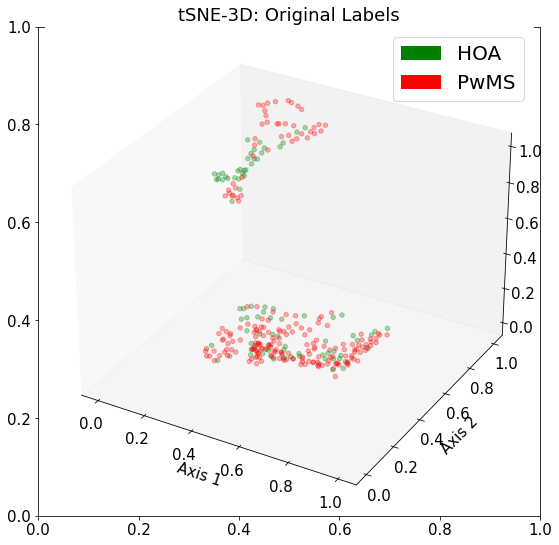

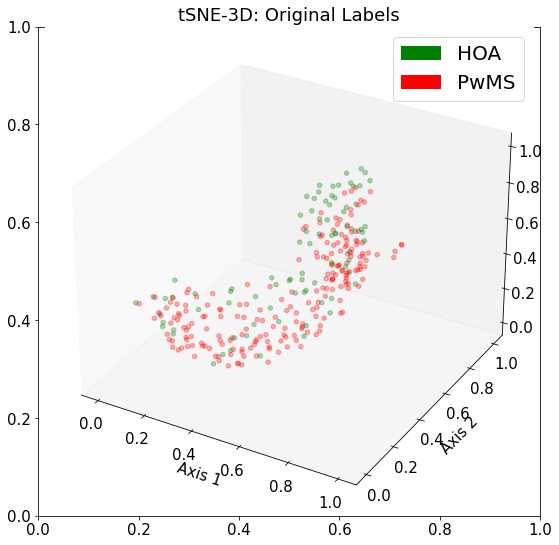

In [86]:
for p in [10, 20]:
    tsne3D(p)

## NMF

In [164]:
#Linear methods: NMF/PCA/ICA
# NMF
model_NMF = decomposition.NMF(n_components=2, init='nndsvda', max_iter=500)
NMF_2D = model_NMF.fit_transform(data_to_reduce)
df = pd.concat((df, pd.DataFrame(NMF_2D, columns = ['NMF_2D_X', 'NMF_2D_Y'])), axis = 1)

model_NMF3 = decomposition.NMF(n_components=3, init='nndsvda', max_iter=200)
NMF_3D = model_NMF3.fit_transform(data_to_reduce)
df = pd.concat((df, pd.DataFrame(NMF_3D, columns = ['NMF_3D_X', 'NMF_3D_Y', 'NMF_3D_Z'])), axis = 1)

# PCA
model_pca = decomposition.PCA(n_components=2)
PCA_2D = model_pca.fit_transform(data_to_reduce)
df = pd.concat((df, pd.DataFrame(NMF_2D, columns = ['PCA_2D_X', 'PCA_2D_Y'])), axis = 1)

model_pca = decomposition.PCA(n_components=3)
PCA_3D = model_pca.fit_transform(data_to_reduce)
df = pd.concat((df, pd.DataFrame(NMF_3D, columns = ['PCA_3D_X', 'PCA_3D_Y', 'PCA_3D_Z'])), axis = 1)

# ICA
model_ICA = decomposition.FastICA(n_components=2)
ICA_2D = model_ICA.fit_transform(data_to_reduce)
model_ICA = decomposition.FastICA(n_components=3)
ICA_3D = model_ICA.fit_transform(data_to_reduce)

In [168]:
data_to_reduce.shape, NMF_2D.shape

((1436, 2048), (1436, 2))

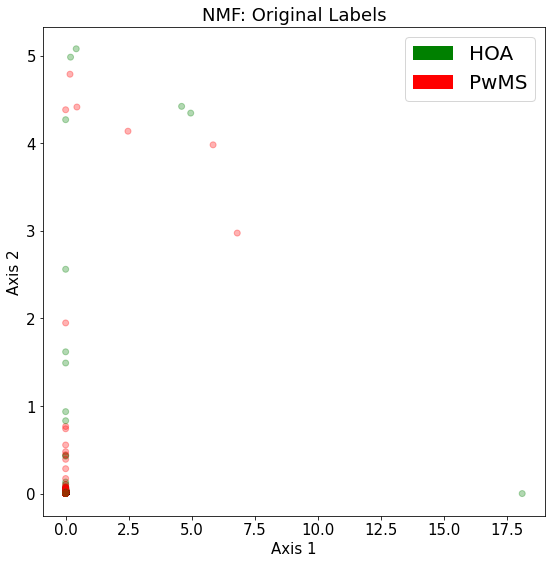

In [165]:
#2D NMF scatter plot 
f = plt.figure(figsize=(9, 9))
ax = f.add_subplot(1, 1, 1)
ax.scatter(NMF_2D[:, 0], NMF_2D[:, 1], c = df['color'], alpha =0.3)
p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc='green')
# p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc='cyan')
p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc='blue')
p4 = plt.Rectangle((0, 0), 0.1, 0.1, fc='red')
ax.legend((p1, p4), ('HOA','PwMS'), loc='best', fontsize = 20);
ax.grid(False)
ax.set_xlabel('Axis 1')
ax.set_ylabel('Axis 2')
ax.set_title("NMF: Original Labels")
plt.savefig('D:\\gait\\results\\SubjectGen_LowDimViz\\fold' + str(fold_to_analyse) + '\\NMF2D_original.png',dpi = 200)

In [ ]:
#3D NMF 
f = plt.figure(figsize=(9, 9))
ax = f.add_subplot(1, 1, 1)
ax = plt.axes(projection='3d')
ax.scatter3D(NMF_3D[:, 0], NMF_3D[:, 1], NMF_3D[:, 2], c = df['color'], alpha =0.3)
p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc='green')
# p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc='cyan')
# p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc='blue')
p4 = plt.Rectangle((0, 0), 0.1, 0.1, fc='red')
ax.legend((p1, p4), ('HOA','PwMS'), loc='best', fontsize = 20);
ax.grid(False)
ax.set_xlabel('Axis 1')
ax.set_ylabel('Axis 2')
ax.set_title("Original Labels")
plt.savefig('D:\\gait\\results\\SubjectGen_LowDimViz\\fold' + str(fold_to_analyse) + '\\NMF3D_original.png',dpi = 200)

## PCA

In [171]:
PCA_2D[:, 0].shape, df['color'].shape

((1436,), (1436,))

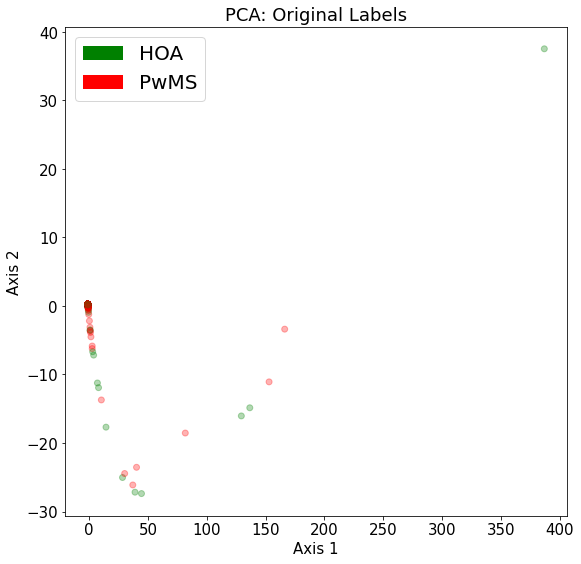

In [169]:
#2D PCA 
f = plt.figure(figsize=(9, 9))
ax = f.add_subplot(1, 1, 1)
ax.scatter(PCA_2D[:, 0], PCA_2D[:, 1], c = df['color'], alpha =0.3)
p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc='green')
# p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc='cyan')
p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc='blue')
p4 = plt.Rectangle((0, 0), 0.1, 0.1, fc='red')
ax.legend((p1, p4), ('HOA','PwMS'), loc='best', fontsize = 20);
ax.grid(False)
ax.set_xlabel('Axis 1')
ax.set_ylabel('Axis 2')
ax.set_title("PCA: Original Labels")
plt.savefig('D:\\gait\\results\\SubjectGen_LowDimViz\\fold' + str(fold_to_analyse) + '\\PCA2D_original.png',dpi = 200)

In [ ]:
#3D PCA
f = plt.figure(figsize=(9, 9))
ax = f.add_subplot(1, 1, 1)
ax = plt.axes(projection='3d')
ax.scatter3D(PCA_3D[:, 0], PCA_3D[:, 1], PCA_3D[:, 2], c = df['color'], alpha =0.3)
p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc='green')
# p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc='cyan')
# p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc='blue')
p4 = plt.Rectangle((0, 0), 0.1, 0.1, fc='red')
ax.legend((p1, p4), ('HOA','PwMS'), loc='best', fontsize = 20);
ax.grid(False)
ax.set_xlabel('Axis 1')
ax.set_ylabel('Axis 2')
ax.set_title("PCA3D: Original Labels")
plt.savefig('D:\\gait\\results\\SubjectGen_LowDimViz\\fold' + str(fold_to_analyse) + '\\PCA3D_original.png',dpi = 200)

## ICA

In [ ]:
#2D ICA 
f = plt.figure(figsize=(9, 9))
ax = f.add_subplot(1, 1, 1)
ax.scatter(ICA_2D[:, 0], ICA_2D[:, 1], c = df['color'], alpha =0.3)
p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc='green')
# p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc='cyan')
p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc='blue')
p4 = plt.Rectangle((0, 0), 0.1, 0.1, fc='red')
ax.legend((p1, p4), ('HOA','PwMS'), loc='best', fontsize = 20);
ax.grid(False)
ax.set_xlabel('Axis 1')
ax.set_ylabel('Axis 2')
ax.set_title("ICA: Original Labels")
plt.savefig('D:\\gait\\results\\TaskGen_LowDimViz\\fold' + str(fold_to_analyse) + '\\ICA2D_original.png',dpi = 200)

In [ ]:
#3D ICA 
f = plt.figure(figsize=(9, 9))
ax = f.add_subplot(1, 1, 1)
ax = plt.axes(projection='3d')
ax.scatter3D(ICA_3D[:, 0], ICA_3D[:, 1], ICA_3D[:, 2], c = df['color'], alpha =0.3)
p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc='green')
# p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc='cyan')
# p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc='blue')
p4 = plt.Rectangle((0, 0), 0.1, 0.1, fc='red')
ax.legend((p1, p4), ('HOA','PwMS'), loc='best', fontsize = 20);
ax.grid(False)
ax.set_xlabel('Axis 1')
ax.set_ylabel('Axis 2')
ax.set_title("ICA3D: Original Labels")
plt.savefig('D:\\gait\\results\\TaskGen_LowDimViz\\fold' + str(fold_to_analyse) + '\\ICA3D_original.png',dpi = 200)

### Fold 2

In [87]:
#Loading the fold 1 pretrained model
skorch_model.initialize() # This is important!
skorch_model.load_params(f_params = path + fold2_model_path)  

#Loading the fold 1 training and test data
fold_to_analyse = 2
train_X, train_Y, test_X, test_Y = load_train_test_X_Y_per_fold(fold_to_analyse)

#Keeping a separate column for the PIDs
train_Y.reset_index(inplace= True)
train_Y.columns = ['PID', 'Label']

test_Y.reset_index(inplace= True)
test_Y.columns = ['PID', 'Label']

setting random seed to:  0
Re-initializing optimizer.


In [88]:
#Processing the read train/test X to 3D tensor of batch_size*time_steps(5)*features(21)
train_X_, test_X_ = [], []

for idx in range(len(train_X)):
    new_data_sample = torch.tensor(train_X.iloc[idx].apply(lambda x : [float(x) for x in x.replace("tensor(", "").replace(")", "").replace("[", "").replace ("]", "").split(",")])).reshape((5, 21))
    train_X_.append(new_data_sample)

for idx in range(len(test_X)):
    new_data_sample = torch.tensor(test_X.iloc[idx].apply(lambda x : [float(x) for x in x.replace("tensor(", "").replace(")", "").replace("[", "").replace ("]", "").split(",")])).reshape((5, 21))
    test_X_.append(new_data_sample)
    
print ('No. of samples in training set for fold', fold_to_analyse, ':', len(train_X_))
print ('No. of samples in testing set for fold', fold_to_analyse, ':', len(test_X_))

#Converting list of tensors to 3D tensor 
train_X_ = torch.stack(train_X_)
test_X_ = torch.stack(test_X_)

print (train_X_.shape, test_X_.shape)

No. of samples in training set for fold 2 : 1148
No. of samples in testing set for fold 2 : 288
torch.Size([1148, 5, 21]) torch.Size([288, 5, 21])


In [89]:
#last layer features for the train set of this fold
skorch_model.module_.forward(train_X_)
last_layer_features_train = skorch_model.module_.lastLayerFeatures
print ('Last layer features for training:', last_layer_features_train.shape)

#Last layer features for the test set of this fold 
skorch_model.module_.forward(test_X_)
last_layer_features_test = skorch_model.module_.lastLayerFeatures
print ('Last layer features for testing:',last_layer_features_test.shape)

Last layer features for training: torch.Size([1148, 2048])
Last layer features for testing: torch.Size([288, 2048])


In [90]:
last_layer_features_train = last_layer_features_train.detach().numpy()
last_layer_features_test = last_layer_features_test.detach().numpy()

train_df = pd.DataFrame(last_layer_features_train)
train_df = pd.concat((train_df, train_Y), axis = 1) #Appending PID and label
train_df['marker'] = 'train' #To mark these data as training set data 

test_df = pd.DataFrame(last_layer_features_test)
test_df = pd.concat((test_df, test_Y), axis = 1) #Appending PID and label
test_df['marker'] = 'test' #To mark these data as testing set data 

#Combining all data last layer features, PID, label along with marker for train/test data
df = pd.concat((train_df, test_df), ignore_index=True)
df['color'] = 'r' #Initially all red
df['color'][df[df['Label']==0].index] = 'g' #Green for controls 

In [91]:
#For only test features 
df = test_df
df['color'] = 'r' #Initially all red
df['color'][df[df['Label']==0].index] = 'g' #Green for controls 

In [92]:
last_layer_features = df[list(range(last_layer_features_test.shape[1]))]
print ((last_layer_features<0).sum().sum())
data_to_reduce = last_layer_features
print ('Dimesions for original last layer test set features: ', data_to_reduce.shape)
data_to_reduce_normalized = StandardScaler().fit_transform(data_to_reduce)

normalize = False #Not normalizing last layer features before feeding to t-SNE 
test = True
train = True

0
Dimesions for original last layer test set features:  (288, 2048)


In [94]:
def tsne_plot(perp = 30):
    # #Linear methods: NMF/PCA/ICA
    # # NMF
    # model_NMF = decomposition.NMF(n_components=2, init='nndsvda', max_iter=500)
    # NMF_2D = model_NMF.fit_transform(data_to_reduce)
    # df = pd.concat((df, pd.DataFrame(NMF_2D, columns = ['NMF_2D_X', 'NMF_2D_Y'])), axis = 1)

    # model_NMF3 = decomposition.NMF(n_components=3, init='nndsvda', max_iter=200)
    # NMF_3D = model_NMF3.fit_transform(data_to_reduce)
    # df = pd.concat((df, pd.DataFrame(NMF_3D, columns = ['NMF_3D_X', 'NMF_3D_Y', 'NMF_3D_Z'])), axis = 1)

    # # PCA
    # model_pca = decomposition.PCA(n_components=2)
    # PCA_2D = model_pca.fit_transform(data_to_reduce)
    # df = pd.concat((df, pd.DataFrame(NMF_2D, columns = ['NMF_2D_X', 'NMF_2D_Y'])), axis = 1)

    # model_pca = decomposition.PCA(n_components=3)
    # PCA_3D = model_pca.fit_transform(data_to_reduce)
    # df = pd.concat((df, pd.DataFrame(NMF_3D, columns = ['NMF_3D_X', 'NMF_3D_Y', 'NMF_3D_Z'])), axis = 1)

    # # ICA
    # model_ICA = decomposition.FastICA(n_components=2)
    # ICA_2D = model_ICA.fit_transform(data_to_reduce)
    # model_ICA = decomposition.FastICA(n_components=3)
    # ICA_3D = model_ICA.fit_transform(data_to_reduce)

    #Non linear methods: t-SNE
    #t-SNE 
    tsne = manifold.TSNE(n_components=2, init='random', random_state=0, perplexity=perp, n_iter = 20000) #2D tsne 

    if normalize:
        tsne_2D = tsne.fit_transform(data_to_reduce_normalized)
    else:
        tsne_2D = tsne.fit_transform(data_to_reduce)

    #Normalizing the t-SNE values after computation 
    tsne_2D_normalized = np.concatenate((min_max_scale(tsne_2D[:, 0]), min_max_scale(tsne_2D[:, 1])), axis = 1)

    #However, if you use the same data and perplexity, you can compare the 
    #Kullback-Leibler divergences that t-SNE reports. It is perfectly fine to 
    #run t-SNE ten times, and select the solution with the lowest KL divergence.
    print ('KL divergence for t-SNE 2D = ', tsne.kl_divergence_, 'with perplexity = ', perp)


    # tsne = manifold.TSNE(n_components=3, init='random', random_state=0, perplexity=30) #3D tsne 
    # tsne_3D = tsne.fit_transform(data_to_reduce)
    
    #2D t-SNE Scatter plot 
    f = plt.figure(figsize=(9, 9))
    ax = f.add_subplot(1, 1, 1)
    ax.scatter(tsne_2D_normalized[:, 0], tsne_2D_normalized[:, 1], c = df['color'], alpha =0.3)
    p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc='green')
    # p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc='cyan')
    p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc='blue')
    p4 = plt.Rectangle((0, 0), 0.1, 0.1, fc='red')
    ax.legend((p1, p4), ('HOA','PwMS'), loc='best', fontsize = 20);
    ax.grid(False)
    ax.set_xlabel('Axis 1')
    ax.set_ylabel('Axis 2')
    ax.set_title("tsne_2D: Original Labels")
    plt.savefig('D:\\gait\\results\\SubjectGen_LowDimViz\\fold' + str(fold_to_analyse) + '\\tsne_2D_original_' + str(perp) + str(normalize) + 'test_' + str(test) + '.png',dpi = 200)
    plt.close()
    
    tsne2D_added_colors = pd.DataFrame(tsne_2D_normalized, df['color'])
    tsne2D_added_colors.columns = ['tsnex', 'tsney']
    x_green = tsne2D_added_colors.loc[tsne2D_added_colors.index=='g']['tsnex'].values
    y_green = tsne2D_added_colors.loc[tsne2D_added_colors.index=='g']['tsney'].values
    x_red =tsne2D_added_colors.loc[tsne2D_added_colors.index=='r']['tsnex'].values
    y_red = tsne2D_added_colors.loc[tsne2D_added_colors.index=='r']['tsney'].values

    #2D t-SNE scatter plot with joint and marginal distributions 
    ###Plotting with the distributions
    mpl.rcParams['axes.spines.top'] = True
    mpl.rcParams['axes.spines.right'] = True
    plt.rcParams['font.size'] = 15
    a = 0.2
    zo=0
    l=12
    p = sns.JointGrid(x = x_red, y = y_red, size = 7)
    p.x = list( x_red)
    p.y = list( y_red)
    p.plot_joint(plt.scatter, c="r", alpha = a)
    p.plot_marginals(sns.distplot, color='r', axlabel=[])
    p.plot_joint(sns.kdeplot, zorder=zo, n_levels=l, cmap="Reds")
#     plt.grid()
    p.x = list( x_green)
    p.y = list( y_green)
    p.plot_joint(plt.scatter, c="g", alpha = a)
    p.plot_marginals(sns.distplot, color='g', axlabel=[])
    p.plot_joint(sns.kdeplot, zorder=zo, n_levels=l, cmap="Greens")
#     plt.grid()
    p.set_axis_labels(xlabel='t-SNE Dimension 1', ylabel='t-SNE Dimension 2')
    # p.ax_joint.set_xticklabels([])
    # p.ax_joint.set_yticklabels([])
    # p.ax_marg_x.legend_.remove()
    p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc= 'green')
    # p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc='blue')
    p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc='red')
    plt.legend((p1,p3), ('HOA','PwMS'), loc='best', fontsize = 15)
    # plt.legend((p1, p2, p3), ('Low', 'Medium', 'High'), loc='best',prop={'size':12});
    # plt.title('Trial W', fontsize = 14)
    plt.xlabel('x-axis', fontsize = 15)
    plt.ylabel('y-axis', fontsize = 15)
#     plt.grid(linestyle='--')
    plt.tight_layout()
    plt.savefig('D:\\gait\\results\\SubjectGen_LowDimViz\\fold' + str(fold_to_analyse) + '\\tsne_2D_original_distributions_' + str(perp) + str(normalize)+ 'test_' + str(test) + '.png', dpi = 300)


KL divergence for t-SNE 2D =  0.4150809943675995 with perplexity =  30
KL divergence for t-SNE 2D =  0.36117953062057495 with perplexity =  50
KL divergence for t-SNE 2D =  0.3191888630390167 with perplexity =  70
KL divergence for t-SNE 2D =  0.2715877294540405 with perplexity =  100


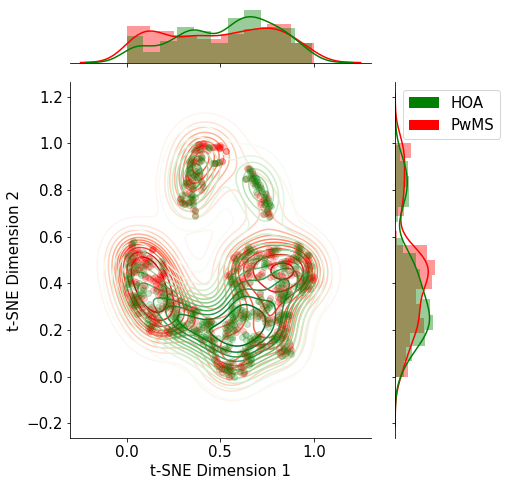

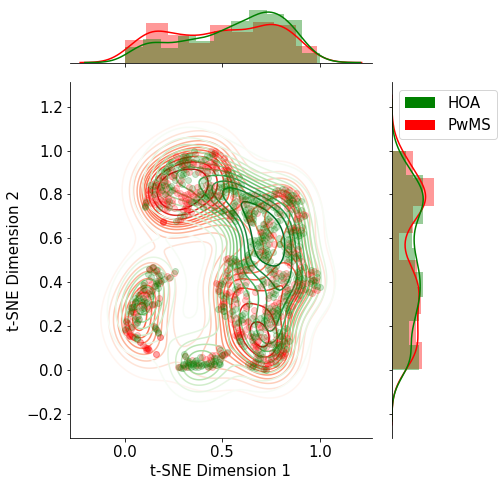

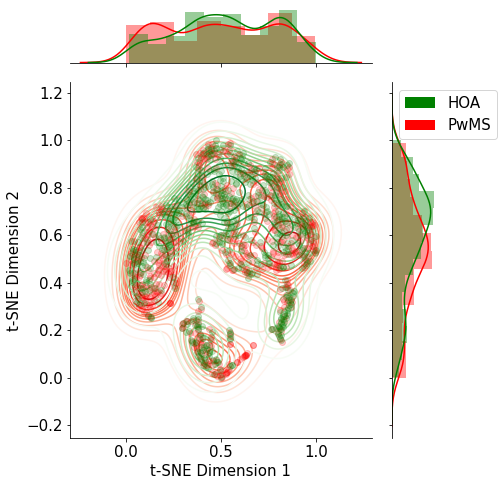

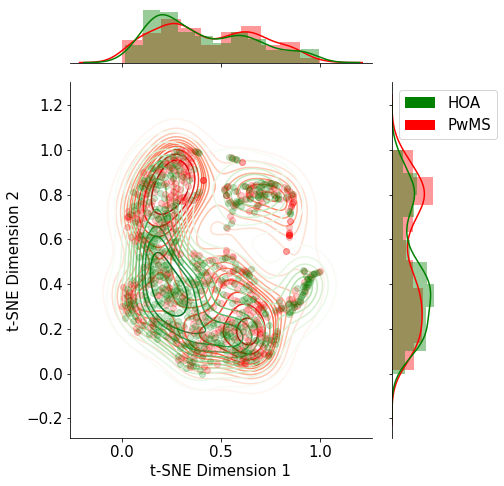

In [337]:
for p in [30, 50, 70, 100]:
    tsne_plot(p)

### 3D t-SNE

In [95]:
#3D t-SNE 
#Non linear methods: t-SNE
#t-SNE 
def tsne3D(perp = 30):
    tsne = manifold.TSNE(n_components=3, init='random', random_state=0, perplexity=perp, n_iter = 20000) #2D tsne 
    tsne_3D = tsne.fit_transform(data_to_reduce)

    #Normalizing the t-SNE values after computation 
    tsne_3D_normalized = np.concatenate((min_max_scale(tsne_3D[:, 0]), min_max_scale(tsne_3D[:, 1]), min_max_scale(tsne_3D[:, 2])), axis = 1)

    #However, if you use the same data and perplexity, you can compare the 
    #Kullback-Leibler divergences that t-SNE reports. It is perfectly fine to 
    #run t-SNE ten times, and select the solution with the lowest KL divergence.
    print ('KL divergence for t-SNE 3D = ', tsne.kl_divergence_, 'with perplexity = ', perp)

    f = plt.figure(figsize=(9, 9))
    ax = f.add_subplot(1, 1, 1)
    ax = plt.axes(projection='3d')
    ax.scatter3D(tsne_3D_normalized[:, 0], tsne_3D_normalized[:, 1], tsne_3D_normalized[:, 2], c = df['color'], alpha =0.3)
    p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc='green')
    # p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc='cyan')
    # p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc='blue')
    p4 = plt.Rectangle((0, 0), 0.1, 0.1, fc='red')
    ax.legend((p1, p4), ('HOA','PwMS'), loc='best', fontsize = 20);
    ax.grid(False)
    ax.set_xlabel('Axis 1')
    ax.set_ylabel('Axis 2')
    ax.set_title("tSNE-3D: Original Labels")
    plt.savefig('D:\\gait\\results\\SubjectGen_LowDimViz\\fold' + str(fold_to_analyse) + '\\tsne3D_original_perp'+str(perp)+ 'test_' + str(test) +'.png',dpi = 200)

KL divergence for t-SNE 3D =  0.667080283164978 with perplexity =  30
KL divergence for t-SNE 3D =  0.7089776992797852 with perplexity =  40
KL divergence for t-SNE 3D =  0.6650701761245728 with perplexity =  50
KL divergence for t-SNE 3D =  0.844806432723999 with perplexity =  60
KL divergence for t-SNE 3D =  1.180292010307312 with perplexity =  70
KL divergence for t-SNE 3D =  1.162721872329712 with perplexity =  80
KL divergence for t-SNE 3D =  1.24910306930542 with perplexity =  90
KL divergence for t-SNE 3D =  1.3950653076171875 with perplexity =  100


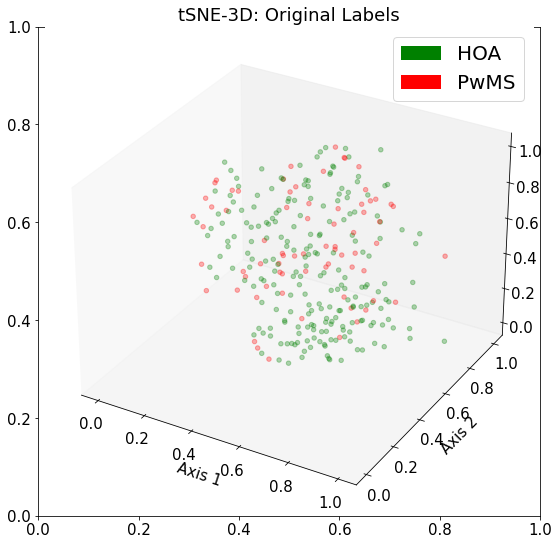

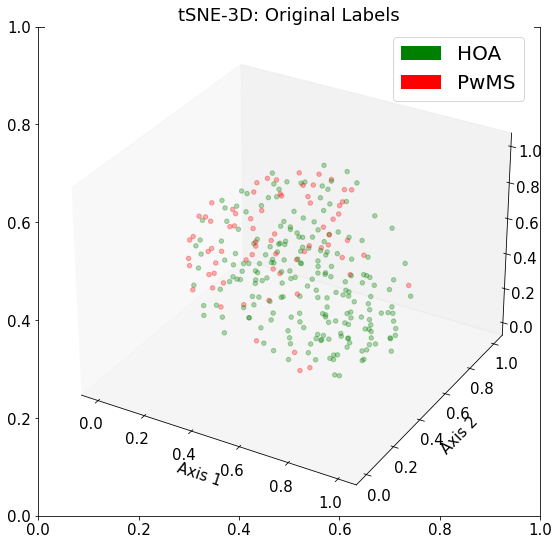

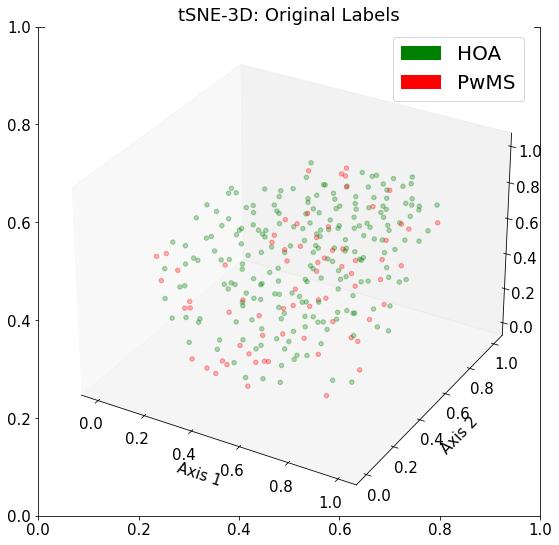

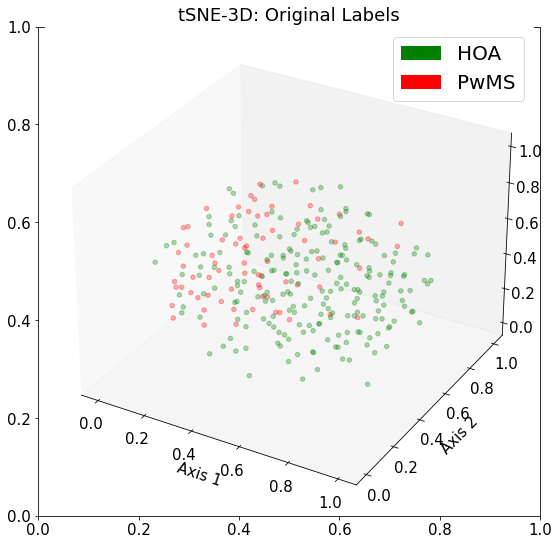

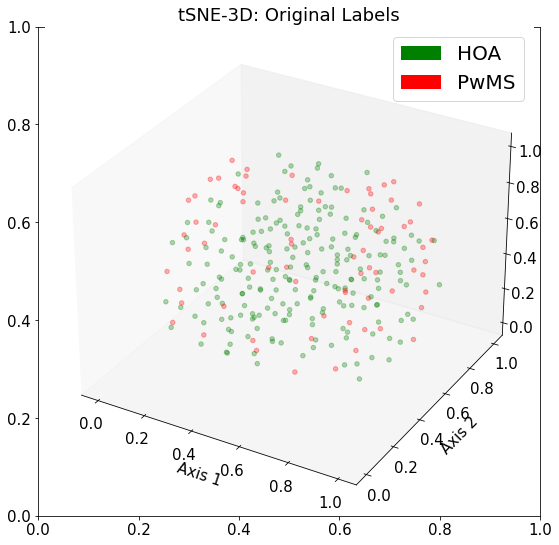

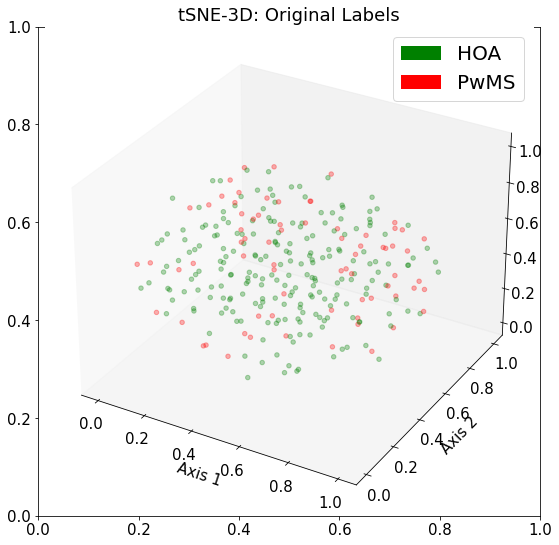

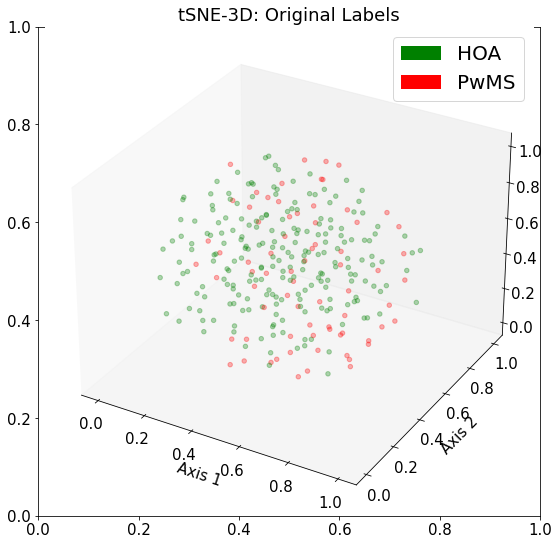

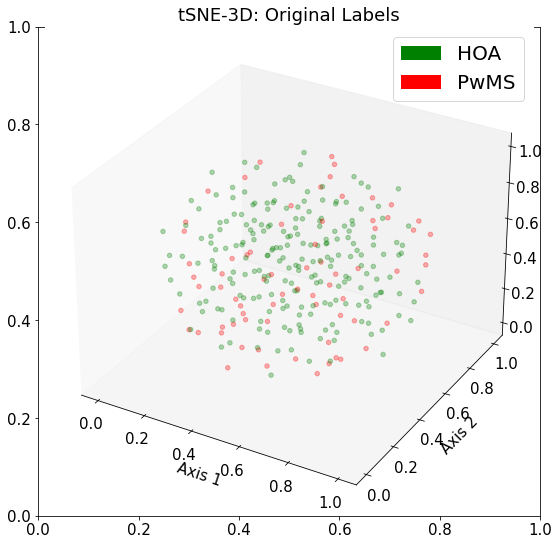

In [97]:
for p in [30, 40, 50, 60, 70, 80, 90, 100]:
    tsne3D(p)

### Fold 3

In [102]:
#Loading the fold 1 pretrained model
skorch_model.initialize() # This is important!
skorch_model.load_params(f_params = path + fold3_model_path)  

#Loading the fold 1 training and test data
fold_to_analyse = 3
train_X, train_Y, test_X, test_Y = load_train_test_X_Y_per_fold(fold_to_analyse)

#Keeping a separate column for the PIDs
train_Y.reset_index(inplace= True)
train_Y.columns = ['PID', 'Label']

test_Y.reset_index(inplace= True)
test_Y.columns = ['PID', 'Label']

setting random seed to:  0
Re-initializing optimizer.


In [103]:
#Processing the read train/test X to 3D tensor of batch_size*time_steps(5)*features(21)
train_X_, test_X_ = [], []

for idx in range(len(train_X)):
    new_data_sample = torch.tensor(train_X.iloc[idx].apply(lambda x : [float(x) for x in x.replace("tensor(", "").replace(")", "").replace("[", "").replace ("]", "").split(",")])).reshape((5, 21))
    train_X_.append(new_data_sample)

for idx in range(len(test_X)):
    new_data_sample = torch.tensor(test_X.iloc[idx].apply(lambda x : [float(x) for x in x.replace("tensor(", "").replace(")", "").replace("[", "").replace ("]", "").split(",")])).reshape((5, 21))
    test_X_.append(new_data_sample)
    
print ('No. of samples in training set for fold', fold_to_analyse, ':', len(train_X_))
print ('No. of samples in testing set for fold', fold_to_analyse, ':', len(test_X_))

#Converting list of tensors to 3D tensor 
train_X_ = torch.stack(train_X_)
test_X_ = torch.stack(test_X_)

print (train_X_.shape, test_X_.shape)

No. of samples in training set for fold 3 : 1156
No. of samples in testing set for fold 3 : 280
torch.Size([1156, 5, 21]) torch.Size([280, 5, 21])


In [104]:
#last layer features for the train set of this fold
skorch_model.module_.forward(train_X_)
last_layer_features_train = skorch_model.module_.lastLayerFeatures
print ('Last layer features for training:', last_layer_features_train.shape)

#Last layer features for the test set of this fold 
skorch_model.module_.forward(test_X_)
last_layer_features_test = skorch_model.module_.lastLayerFeatures
print ('Last layer features for testing:',last_layer_features_test.shape)

Last layer features for training: torch.Size([1156, 2048])
Last layer features for testing: torch.Size([280, 2048])


In [105]:
last_layer_features_train = last_layer_features_train.detach().numpy()
last_layer_features_test = last_layer_features_test.detach().numpy()

train_df = pd.DataFrame(last_layer_features_train)
train_df = pd.concat((train_df, train_Y), axis = 1) #Appending PID and label
train_df['marker'] = 'train' #To mark these data as training set data 

test_df = pd.DataFrame(last_layer_features_test)
test_df = pd.concat((test_df, test_Y), axis = 1) #Appending PID and label
test_df['marker'] = 'test' #To mark these data as testing set data 

#Combining all data last layer features, PID, label along with marker for train/test data
df = pd.concat((train_df, test_df), ignore_index=True)
df['color'] = 'r' #Initially all red
df['color'][df[df['Label']==0].index] = 'g' #Green for controls 

In [21]:
# #For only test features 
# df = test_df
# df['color'] = 'r' #Initially all red
# df['color'][df[df['Label']==0].index] = 'g' #Green for controls 

In [106]:
last_layer_features = df[list(range(last_layer_features_test.shape[1]))]
print ((last_layer_features<0).sum().sum())
data_to_reduce = last_layer_features
print ('Dimesions for original last layer test set features: ', data_to_reduce.shape)
data_to_reduce_normalized = StandardScaler().fit_transform(data_to_reduce)

normalize = False #Not normalizing last layer features before feeding to t-SNE 
test = False

0
Dimesions for original last layer test set features:  (1436, 2048)


In [107]:
def tsne_plot(perp = 30):
    # #Linear methods: NMF/PCA/ICA
    # # NMF
    # model_NMF = decomposition.NMF(n_components=2, init='nndsvda', max_iter=500)
    # NMF_2D = model_NMF.fit_transform(data_to_reduce)
    # df = pd.concat((df, pd.DataFrame(NMF_2D, columns = ['NMF_2D_X', 'NMF_2D_Y'])), axis = 1)

    # model_NMF3 = decomposition.NMF(n_components=3, init='nndsvda', max_iter=200)
    # NMF_3D = model_NMF3.fit_transform(data_to_reduce)
    # df = pd.concat((df, pd.DataFrame(NMF_3D, columns = ['NMF_3D_X', 'NMF_3D_Y', 'NMF_3D_Z'])), axis = 1)

    # # PCA
    # model_pca = decomposition.PCA(n_components=2)
    # PCA_2D = model_pca.fit_transform(data_to_reduce)
    # df = pd.concat((df, pd.DataFrame(NMF_2D, columns = ['NMF_2D_X', 'NMF_2D_Y'])), axis = 1)

    # model_pca = decomposition.PCA(n_components=3)
    # PCA_3D = model_pca.fit_transform(data_to_reduce)
    # df = pd.concat((df, pd.DataFrame(NMF_3D, columns = ['NMF_3D_X', 'NMF_3D_Y', 'NMF_3D_Z'])), axis = 1)

    # # ICA
    # model_ICA = decomposition.FastICA(n_components=2)
    # ICA_2D = model_ICA.fit_transform(data_to_reduce)
    # model_ICA = decomposition.FastICA(n_components=3)
    # ICA_3D = model_ICA.fit_transform(data_to_reduce)

    #Non linear methods: t-SNE
    #t-SNE 
    tsne = manifold.TSNE(n_components=2, init='random', random_state=0, perplexity=perp, n_iter = 20000) #2D tsne 

    if normalize:
        tsne_2D = tsne.fit_transform(data_to_reduce_normalized)
    else:
        tsne_2D = tsne.fit_transform(data_to_reduce)

    #Normalizing the t-SNE values after computation 
    tsne_2D_normalized = np.concatenate((min_max_scale(tsne_2D[:, 0]), min_max_scale(tsne_2D[:, 1])), axis = 1)

    #However, if you use the same data and perplexity, you can compare the 
    #Kullback-Leibler divergences that t-SNE reports. It is perfectly fine to 
    #run t-SNE ten times, and select the solution with the lowest KL divergence.
    print ('KL divergence for t-SNE 2D = ', tsne.kl_divergence_, 'with perplexity = ', perp)


    # tsne = manifold.TSNE(n_components=3, init='random', random_state=0, perplexity=30) #3D tsne 
    # tsne_3D = tsne.fit_transform(data_to_reduce)
    
    #2D t-SNE Scatter plot 
    f = plt.figure(figsize=(9, 9))
    ax = f.add_subplot(1, 1, 1)
    ax.scatter(tsne_2D_normalized[:, 0], tsne_2D_normalized[:, 1], c = df['color'], alpha =0.3)
    p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc='green')
    # p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc='cyan')
    p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc='blue')
    p4 = plt.Rectangle((0, 0), 0.1, 0.1, fc='red')
    ax.legend((p1, p4), ('HOA','PwMS'), loc='best', fontsize = 20);
    ax.grid(False)
    ax.set_xlabel('Axis 1')
    ax.set_ylabel('Axis 2')
    ax.set_title("tsne_2D: Original Labels")
    plt.savefig('D:\\gait\\results\\SubjectGen_LowDimViz\\fold' + str(fold_to_analyse) + '\\tsne_2D_original_' + str(perp) + str(normalize) + 'test_' + str(test) + '.png',dpi = 200)
    plt.close()
    
    tsne2D_added_colors = pd.DataFrame(tsne_2D_normalized, df['color'])
    tsne2D_added_colors.columns = ['tsnex', 'tsney']
    x_green = tsne2D_added_colors.loc[tsne2D_added_colors.index=='g']['tsnex'].values
    y_green = tsne2D_added_colors.loc[tsne2D_added_colors.index=='g']['tsney'].values
    x_red =tsne2D_added_colors.loc[tsne2D_added_colors.index=='r']['tsnex'].values
    y_red = tsne2D_added_colors.loc[tsne2D_added_colors.index=='r']['tsney'].values

    #2D t-SNE scatter plot with joint and marginal distributions 
    ###Plotting with the distributions
    mpl.rcParams['axes.spines.top'] = True
    mpl.rcParams['axes.spines.right'] = True
    plt.rcParams['font.size'] = 15
    a = 0.2
    zo=0
    l=12
    p = sns.JointGrid(x = x_red, y = y_red, size = 7)
    p.x = list( x_red)
    p.y = list( y_red)
    p.plot_joint(plt.scatter, c="r", alpha = a)
    p.plot_marginals(sns.distplot, color='r', axlabel=[])
    p.plot_joint(sns.kdeplot, zorder=zo, n_levels=l, cmap="Reds")
#     plt.grid()
    p.x = list( x_green)
    p.y = list( y_green)
    p.plot_joint(plt.scatter, c="g", alpha = a)
    p.plot_marginals(sns.distplot, color='g', axlabel=[])
    p.plot_joint(sns.kdeplot, zorder=zo, n_levels=l, cmap="Greens")
#     plt.grid()
    p.set_axis_labels(xlabel='t-SNE Dimension 1', ylabel='t-SNE Dimension 2')
    # p.ax_joint.set_xticklabels([])
    # p.ax_joint.set_yticklabels([])
    # p.ax_marg_x.legend_.remove()
    p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc= 'green')
    # p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc='blue')
    p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc='red')
    plt.legend((p1,p3), ('HOA','PwMS'), loc='best', fontsize = 15)
    # plt.legend((p1, p2, p3), ('Low', 'Medium', 'High'), loc='best',prop={'size':12});
    # plt.title('Trial W', fontsize = 14)
    plt.xlabel('x-axis', fontsize = 15)
    plt.ylabel('y-axis', fontsize = 15)
#     plt.grid(linestyle='--')
    plt.tight_layout()
    plt.savefig('D:\\gait\\results\\SubjectGen_LowDimViz\\fold' + str(fold_to_analyse) + '\\tsne_2D_original_distributions_' + str(perp) + str(normalize)+ 'test_' + str(test) + '.png', dpi = 300)


KL divergence for t-SNE 2D =  0.09647087752819061 with perplexity =  120
KL divergence for t-SNE 2D =  0.05203340947628021 with perplexity =  130
KL divergence for t-SNE 2D =  0.04069334641098976 with perplexity =  150
KL divergence for t-SNE 2D =  0.023992912843823433 with perplexity =  170
KL divergence for t-SNE 2D =  0.016455860808491707 with perplexity =  200


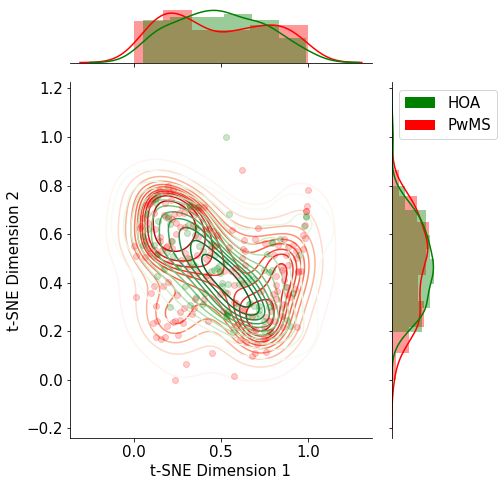

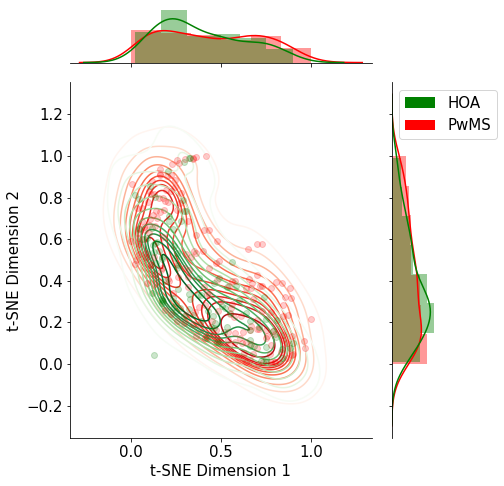

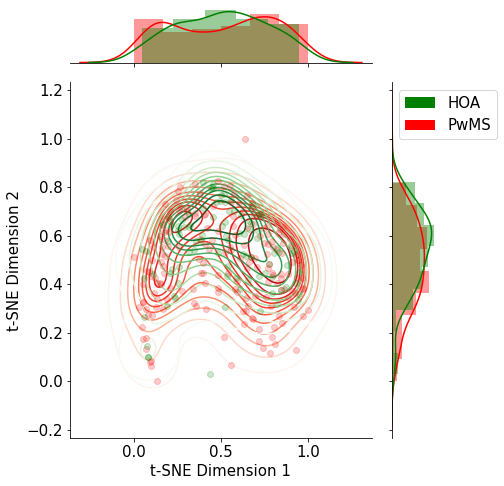

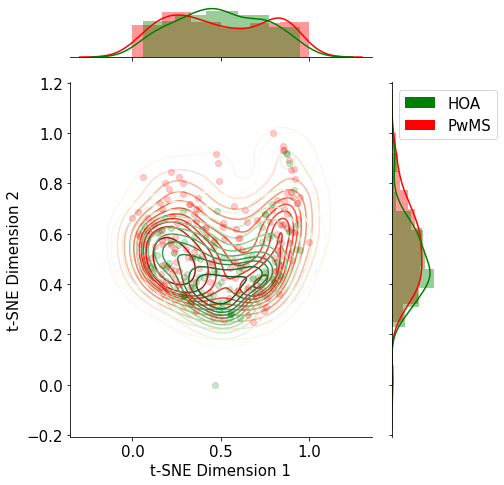

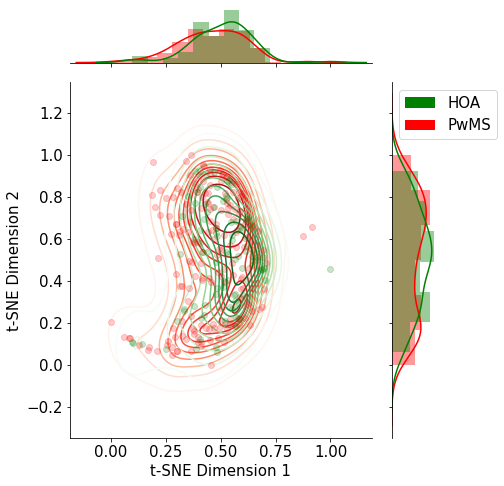

In [25]:
for p in [120, 130, 150, 170, 200]:
    tsne_plot(p)

### 3D t-SNE

In [108]:
#3D t-SNE 
#Non linear methods: t-SNE
#t-SNE 
def tsne3D(perp = 30):
    tsne = manifold.TSNE(n_components=3, init='random', random_state=0, perplexity=perp, n_iter = 20000) #2D tsne 
    tsne_3D = tsne.fit_transform(data_to_reduce)

    #Normalizing the t-SNE values after computation 
    tsne_3D_normalized = np.concatenate((min_max_scale(tsne_3D[:, 0]), min_max_scale(tsne_3D[:, 1]), min_max_scale(tsne_3D[:, 2])), axis = 1)

    #However, if you use the same data and perplexity, you can compare the 
    #Kullback-Leibler divergences that t-SNE reports. It is perfectly fine to 
    #run t-SNE ten times, and select the solution with the lowest KL divergence.
    print ('KL divergence for t-SNE 3D = ', tsne.kl_divergence_, 'with perplexity = ', perp)

    f = plt.figure(figsize=(9, 9))
    ax = f.add_subplot(1, 1, 1)
    ax = plt.axes(projection='3d')
    ax.scatter3D(tsne_3D_normalized[:, 0], tsne_3D_normalized[:, 1], tsne_3D_normalized[:, 2], c = df['color'], alpha =0.3)
    p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc='green')
    # p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc='cyan')
    # p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc='blue')
    p4 = plt.Rectangle((0, 0), 0.1, 0.1, fc='red')
    ax.legend((p1, p4), ('HOA','PwMS'), loc='best', fontsize = 20);
    ax.grid(False)
    ax.set_xlabel('Axis 1')
    ax.set_ylabel('Axis 2')
    ax.set_title("tSNE-3D: Original Labels")
    plt.savefig('D:\\gait\\results\\SubjectGen_LowDimViz\\fold' + str(fold_to_analyse) + '\\tsne3D_original_perp'+str(perp)+ 'test_' + str(test) +'.png',dpi = 200)

KL divergence for t-SNE 3D =  0.4284459352493286 with perplexity =  30
KL divergence for t-SNE 3D =  0.38762661814689636 with perplexity =  40
KL divergence for t-SNE 3D =  0.3580663800239563 with perplexity =  50
KL divergence for t-SNE 3D =  0.33146944642066956 with perplexity =  60
KL divergence for t-SNE 3D =  0.31447291374206543 with perplexity =  70
KL divergence for t-SNE 3D =  0.29625874757766724 with perplexity =  80
KL divergence for t-SNE 3D =  0.2782742381095886 with perplexity =  90
KL divergence for t-SNE 3D =  0.25402456521987915 with perplexity =  100


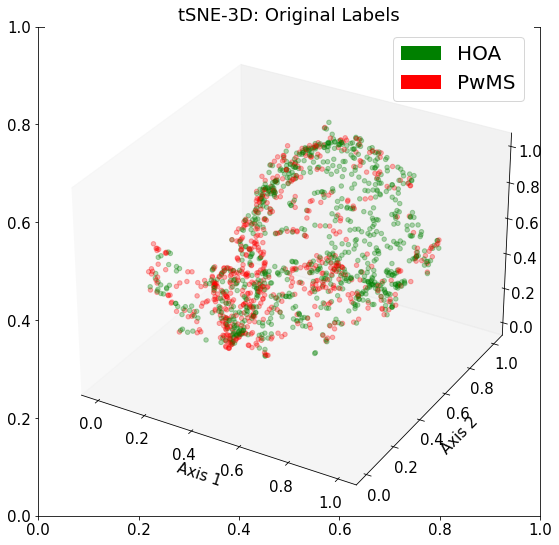

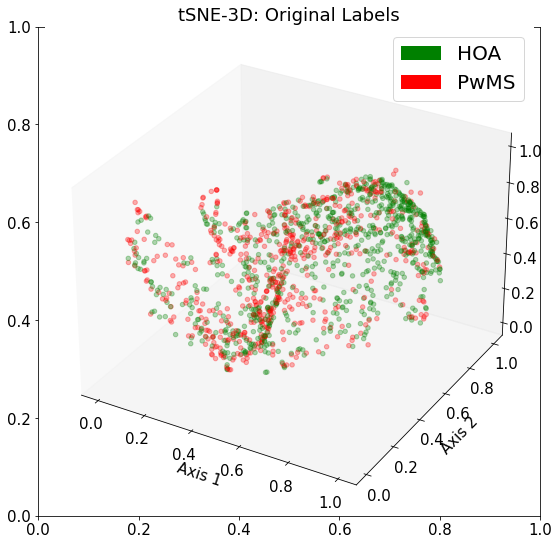

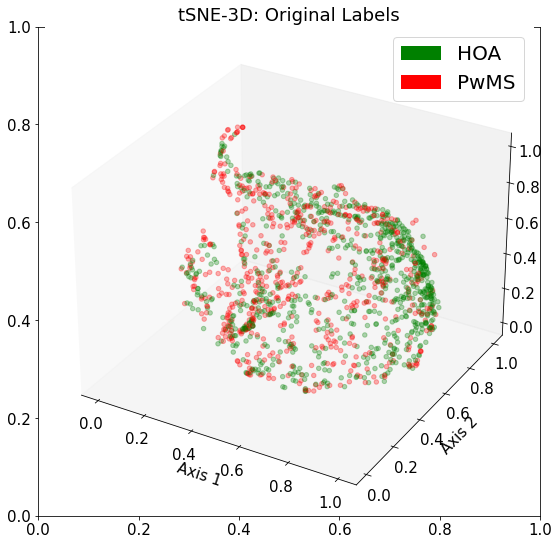

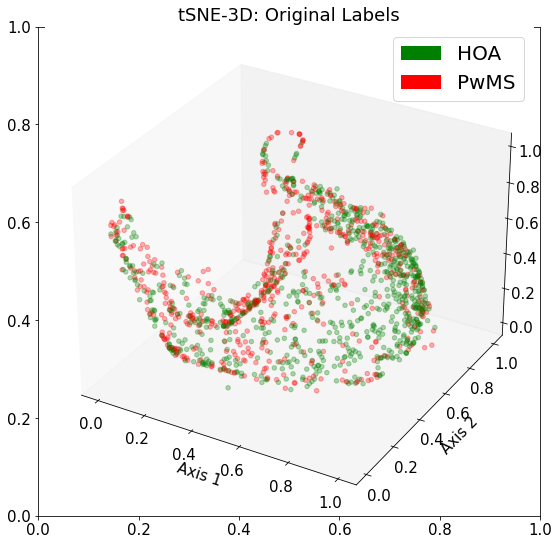

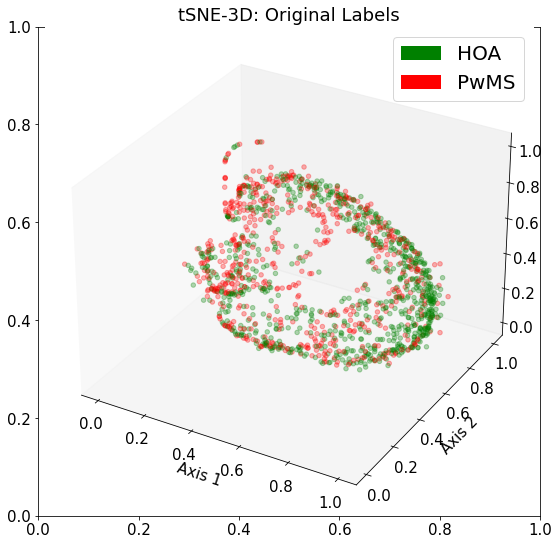

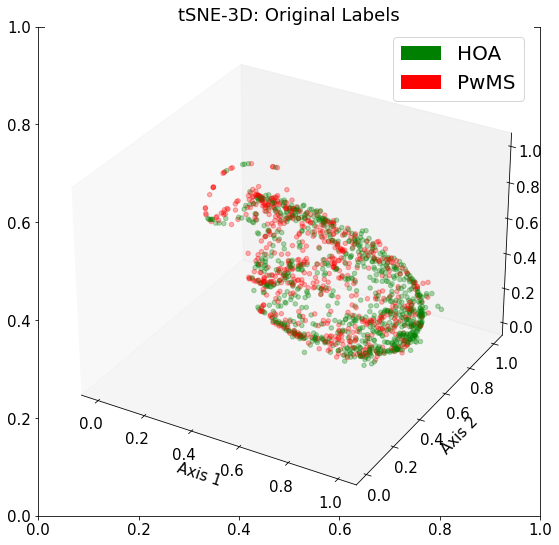

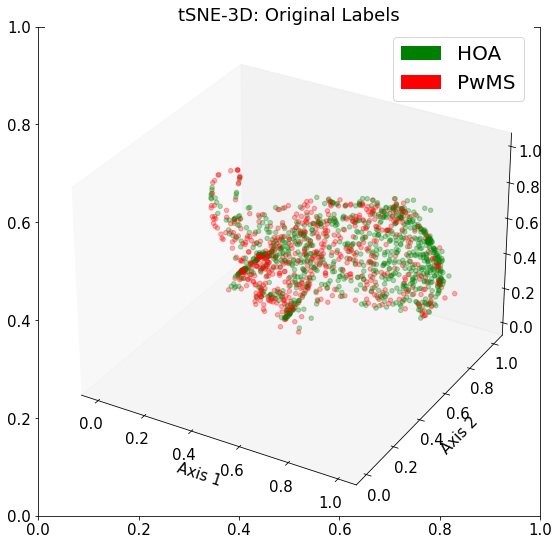

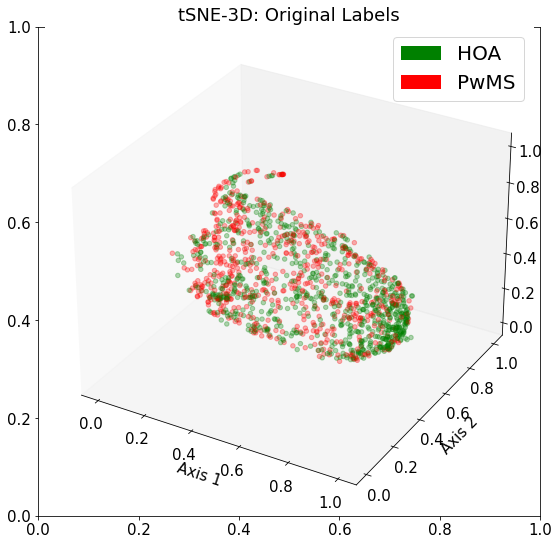

In [109]:
for p in [30, 40, 50, 60, 70, 80, 90, 100]:
    tsne3D(p)

### Fold 4

In [110]:
#Loading the fold 1 pretrained model
skorch_model.initialize() # This is important!
skorch_model.load_params(f_params = path + fold4_model_path)  

#Loading the fold 1 training and test data
fold_to_analyse = 4
train_X, train_Y, test_X, test_Y = load_train_test_X_Y_per_fold(fold_to_analyse)

#Keeping a separate column for the PIDs
train_Y.reset_index(inplace= True)
train_Y.columns = ['PID', 'Label']

test_Y.reset_index(inplace= True)
test_Y.columns = ['PID', 'Label']

setting random seed to:  0
Re-initializing optimizer.


In [111]:
#Processing the read train/test X to 3D tensor of batch_size*time_steps(5)*features(21)
train_X_, test_X_ = [], []

for idx in range(len(train_X)):
    new_data_sample = torch.tensor(train_X.iloc[idx].apply(lambda x : [float(x) for x in x.replace("tensor(", "").replace(")", "").replace("[", "").replace ("]", "").split(",")])).reshape((5, 21))
    train_X_.append(new_data_sample)

for idx in range(len(test_X)):
    new_data_sample = torch.tensor(test_X.iloc[idx].apply(lambda x : [float(x) for x in x.replace("tensor(", "").replace(")", "").replace("[", "").replace ("]", "").split(",")])).reshape((5, 21))
    test_X_.append(new_data_sample)
    
print ('No. of samples in training set for fold', fold_to_analyse, ':', len(train_X_))
print ('No. of samples in testing set for fold', fold_to_analyse, ':', len(test_X_))

#Converting list of tensors to 3D tensor 
train_X_ = torch.stack(train_X_)
test_X_ = torch.stack(test_X_)

print (train_X_.shape, test_X_.shape)

No. of samples in training set for fold 4 : 1149
No. of samples in testing set for fold 4 : 287
torch.Size([1149, 5, 21]) torch.Size([287, 5, 21])


In [112]:
#last layer features for the train set of this fold
skorch_model.module_.forward(train_X_)
last_layer_features_train = skorch_model.module_.lastLayerFeatures
print ('Last layer features for training:', last_layer_features_train.shape)

#Last layer features for the test set of this fold 
skorch_model.module_.forward(test_X_)
last_layer_features_test = skorch_model.module_.lastLayerFeatures
print ('Last layer features for testing:',last_layer_features_test.shape)

Last layer features for training: torch.Size([1149, 2048])
Last layer features for testing: torch.Size([287, 2048])


In [113]:
last_layer_features_train = last_layer_features_train.detach().numpy()
last_layer_features_test = last_layer_features_test.detach().numpy()

train_df = pd.DataFrame(last_layer_features_train)
train_df = pd.concat((train_df, train_Y), axis = 1) #Appending PID and label
train_df['marker'] = 'train' #To mark these data as training set data 

test_df = pd.DataFrame(last_layer_features_test)
test_df = pd.concat((test_df, test_Y), axis = 1) #Appending PID and label
test_df['marker'] = 'test' #To mark these data as testing set data 

#Combining all data last layer features, PID, label along with marker for train/test data
df = pd.concat((train_df, test_df), ignore_index=True)
df['color'] = 'r' #Initially all red
df['color'][df[df['Label']==0].index] = 'g' #Green for controls 

In [118]:
#For only test features 
df = test_df
df['color'] = 'r' #Initially all red
df['color'][df[df['Label']==0].index] = 'g' #Green for controls 

In [119]:
last_layer_features = df[list(range(last_layer_features_test.shape[1]))]
print ((last_layer_features<0).sum().sum())
data_to_reduce = last_layer_features
print ('Dimesions for original last layer test set features: ', data_to_reduce.shape)
data_to_reduce_normalized = StandardScaler().fit_transform(data_to_reduce)

normalize = False #Not normalizing last layer features before feeding to t-SNE 
test = True

0
Dimesions for original last layer test set features:  (287, 2048)


In [35]:
def tsne_plot(perp = 30):
    # #Linear methods: NMF/PCA/ICA
    # # NMF
    # model_NMF = decomposition.NMF(n_components=2, init='nndsvda', max_iter=500)
    # NMF_2D = model_NMF.fit_transform(data_to_reduce)
    # df = pd.concat((df, pd.DataFrame(NMF_2D, columns = ['NMF_2D_X', 'NMF_2D_Y'])), axis = 1)

    # model_NMF3 = decomposition.NMF(n_components=3, init='nndsvda', max_iter=200)
    # NMF_3D = model_NMF3.fit_transform(data_to_reduce)
    # df = pd.concat((df, pd.DataFrame(NMF_3D, columns = ['NMF_3D_X', 'NMF_3D_Y', 'NMF_3D_Z'])), axis = 1)

    # # PCA
    # model_pca = decomposition.PCA(n_components=2)
    # PCA_2D = model_pca.fit_transform(data_to_reduce)
    # df = pd.concat((df, pd.DataFrame(NMF_2D, columns = ['NMF_2D_X', 'NMF_2D_Y'])), axis = 1)

    # model_pca = decomposition.PCA(n_components=3)
    # PCA_3D = model_pca.fit_transform(data_to_reduce)
    # df = pd.concat((df, pd.DataFrame(NMF_3D, columns = ['NMF_3D_X', 'NMF_3D_Y', 'NMF_3D_Z'])), axis = 1)

    # # ICA
    # model_ICA = decomposition.FastICA(n_components=2)
    # ICA_2D = model_ICA.fit_transform(data_to_reduce)
    # model_ICA = decomposition.FastICA(n_components=3)
    # ICA_3D = model_ICA.fit_transform(data_to_reduce)

    #Non linear methods: t-SNE
    #t-SNE 
    tsne = manifold.TSNE(n_components=2, init='random', random_state=0, perplexity=perp, n_iter = 20000) #2D tsne 

    if normalize:
        tsne_2D = tsne.fit_transform(data_to_reduce_normalized)
    else:
        tsne_2D = tsne.fit_transform(data_to_reduce)

    #Normalizing the t-SNE values after computation 
    tsne_2D_normalized = np.concatenate((min_max_scale(tsne_2D[:, 0]), min_max_scale(tsne_2D[:, 1])), axis = 1)

    #However, if you use the same data and perplexity, you can compare the 
    #Kullback-Leibler divergences that t-SNE reports. It is perfectly fine to 
    #run t-SNE ten times, and select the solution with the lowest KL divergence.
    print ('KL divergence for t-SNE 2D = ', tsne.kl_divergence_, 'with perplexity = ', perp)


    # tsne = manifold.TSNE(n_components=3, init='random', random_state=0, perplexity=30) #3D tsne 
    # tsne_3D = tsne.fit_transform(data_to_reduce)
    
    #2D t-SNE Scatter plot 
    f = plt.figure(figsize=(9, 9))
    ax = f.add_subplot(1, 1, 1)
    ax.scatter(tsne_2D_normalized[:, 0], tsne_2D_normalized[:, 1], c = df['color'], alpha =0.3)
    p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc='green')
    # p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc='cyan')
    p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc='blue')
    p4 = plt.Rectangle((0, 0), 0.1, 0.1, fc='red')
    ax.legend((p1, p4), ('HOA','PwMS'), loc='best', fontsize = 20);
    ax.grid(False)
    ax.set_xlabel('Axis 1')
    ax.set_ylabel('Axis 2')
    ax.set_title("tsne_2D: Original Labels")
    plt.savefig('D:\\gait\\results\\SubjectGen_LowDimViz\\fold' + str(fold_to_analyse) + '\\tsne_2D_original_' + str(perp) + str(normalize) + 'test_' + str(test) + '.png',dpi = 200)
    plt.close()
    
    tsne2D_added_colors = pd.DataFrame(tsne_2D_normalized, df['color'])
    tsne2D_added_colors.columns = ['tsnex', 'tsney']
    x_green = tsne2D_added_colors.loc[tsne2D_added_colors.index=='g']['tsnex'].values
    y_green = tsne2D_added_colors.loc[tsne2D_added_colors.index=='g']['tsney'].values
    x_red =tsne2D_added_colors.loc[tsne2D_added_colors.index=='r']['tsnex'].values
    y_red = tsne2D_added_colors.loc[tsne2D_added_colors.index=='r']['tsney'].values

    #2D t-SNE scatter plot with joint and marginal distributions 
    ###Plotting with the distributions
    mpl.rcParams['axes.spines.top'] = True
    mpl.rcParams['axes.spines.right'] = True
    plt.rcParams['font.size'] = 15
    a = 0.2
    zo=0
    l=12
    p = sns.JointGrid(x = x_red, y = y_red, size = 7)
    p.x = list( x_red)
    p.y = list( y_red)
    p.plot_joint(plt.scatter, c="r", alpha = a)
    p.plot_marginals(sns.distplot, color='r', axlabel=[])
    p.plot_joint(sns.kdeplot, zorder=zo, n_levels=l, cmap="Reds")
#     plt.grid()
    p.x = list( x_green)
    p.y = list( y_green)
    p.plot_joint(plt.scatter, c="g", alpha = a)
    p.plot_marginals(sns.distplot, color='g', axlabel=[])
    p.plot_joint(sns.kdeplot, zorder=zo, n_levels=l, cmap="Greens")
#     plt.grid()
    p.set_axis_labels(xlabel='t-SNE Dimension 1', ylabel='t-SNE Dimension 2')
    # p.ax_joint.set_xticklabels([])
    # p.ax_joint.set_yticklabels([])
    # p.ax_marg_x.legend_.remove()
    p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc= 'green')
    # p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc='blue')
    p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc='red')
    plt.legend((p1,p3), ('HOA','PwMS'), loc='best', fontsize = 15)
    # plt.legend((p1, p2, p3), ('Low', 'Medium', 'High'), loc='best',prop={'size':12});
    # plt.title('Trial W', fontsize = 14)
    plt.xlabel('x-axis', fontsize = 15)
    plt.ylabel('y-axis', fontsize = 15)
#     plt.grid(linestyle='--')
    plt.tight_layout()
    plt.savefig('D:\\gait\\results\\SubjectGen_LowDimViz\\fold' + str(fold_to_analyse) + '\\tsne_2D_original_distributions_' + str(perp) + str(normalize)+ 'test_' + str(test) + '.png', dpi = 300)


KL divergence for t-SNE 2D =  0.06742750853300095 with perplexity =  110
KL divergence for t-SNE 2D =  0.10623873770236969 with perplexity =  120
KL divergence for t-SNE 2D =  0.05931956693530083 with perplexity =  130
KL divergence for t-SNE 2D =  0.05544997751712799 with perplexity =  140
KL divergence for t-SNE 2D =  0.05368410050868988 with perplexity =  150
KL divergence for t-SNE 2D =  0.05623198673129082 with perplexity =  160
KL divergence for t-SNE 2D =  0.04864518344402313 with perplexity =  170
KL divergence for t-SNE 2D =  0.036117762327194214 with perplexity =  200


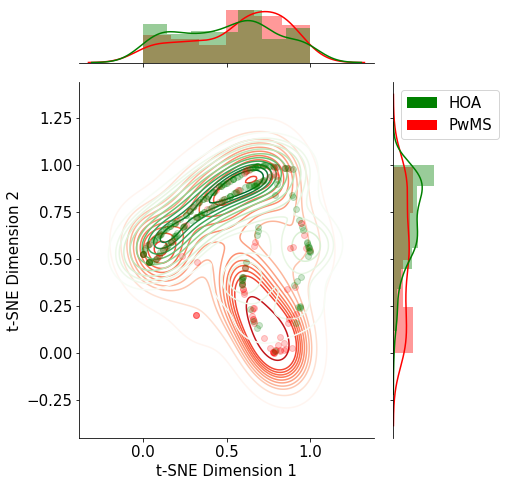

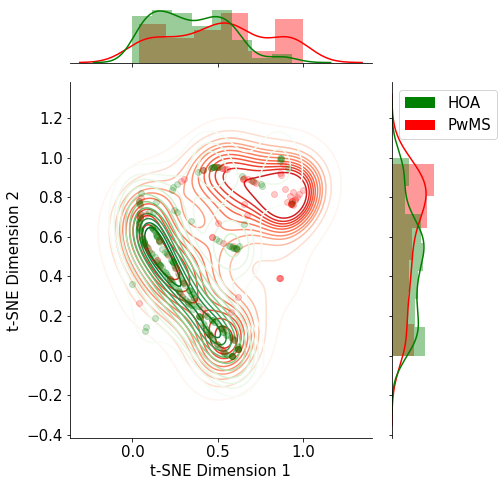

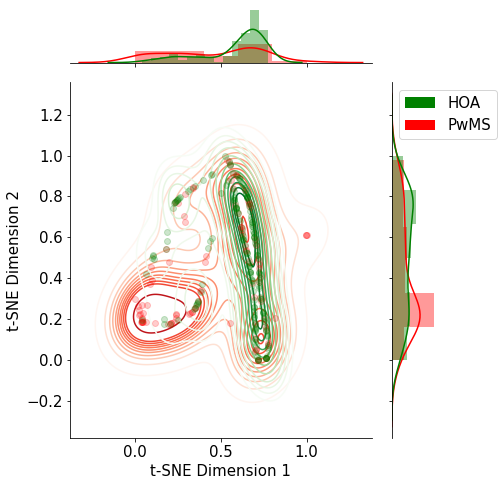

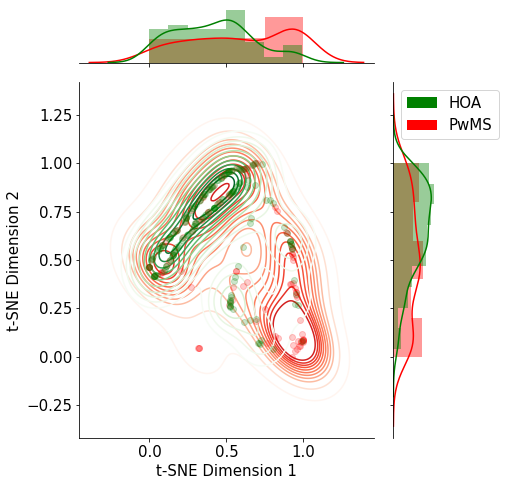

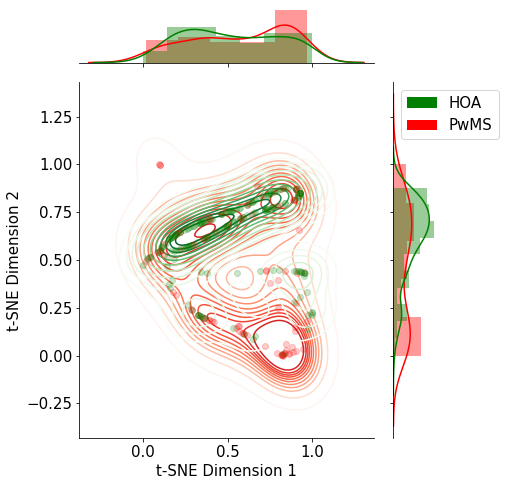

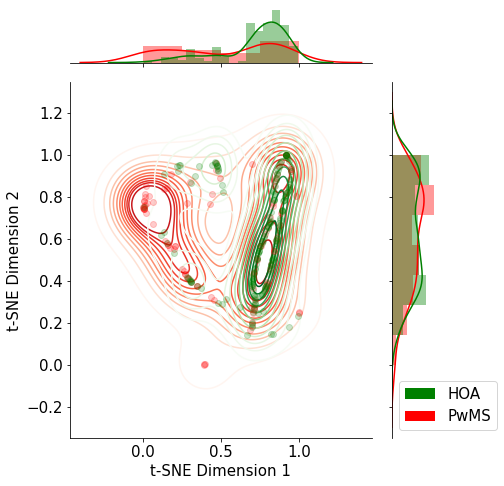

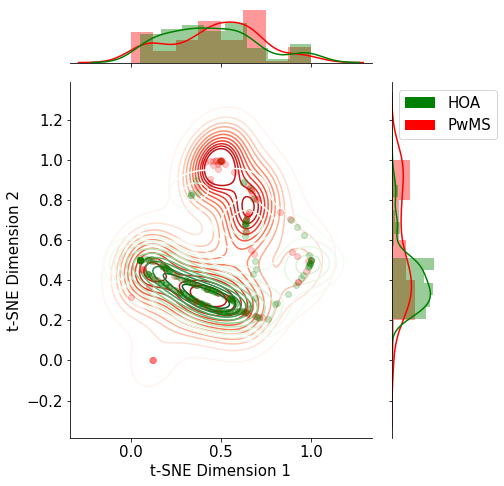

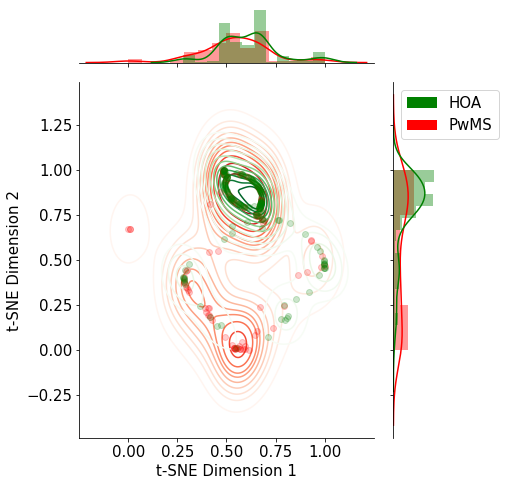

In [37]:
for p in [110, 120, 130, 140, 150, 160, 170, 200]:
    tsne_plot(p)

### 3D t-SNE

In [120]:
#3D t-SNE 
#Non linear methods: t-SNE
#t-SNE 
def tsne3D(perp = 30):
    tsne = manifold.TSNE(n_components=3, init='random', random_state=0, perplexity=perp, n_iter = 20000) #2D tsne 
    tsne_3D = tsne.fit_transform(data_to_reduce)

    #Normalizing the t-SNE values after computation 
    tsne_3D_normalized = np.concatenate((min_max_scale(tsne_3D[:, 0]), min_max_scale(tsne_3D[:, 1]), min_max_scale(tsne_3D[:, 2])), axis = 1)

    #However, if you use the same data and perplexity, you can compare the 
    #Kullback-Leibler divergences that t-SNE reports. It is perfectly fine to 
    #run t-SNE ten times, and select the solution with the lowest KL divergence.
    print ('KL divergence for t-SNE 3D = ', tsne.kl_divergence_, 'with perplexity = ', perp)

    f = plt.figure(figsize=(9, 9))
    ax = f.add_subplot(1, 1, 1)
    ax = plt.axes(projection='3d')
    ax.scatter3D(tsne_3D_normalized[:, 0], tsne_3D_normalized[:, 1], tsne_3D_normalized[:, 2], c = df['color'], alpha =0.3)
    p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc='green')
    # p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc='cyan')
    # p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc='blue')
    p4 = plt.Rectangle((0, 0), 0.1, 0.1, fc='red')
    ax.legend((p1, p4), ('HOA','PwMS'), loc='best', fontsize = 20);
    ax.grid(False)
    ax.set_xlabel('Axis 1')
    ax.set_ylabel('Axis 2')
    ax.set_title("tSNE-3D: Original Labels")
    plt.savefig('D:\\gait\\results\\SubjectGen_LowDimViz\\fold' + str(fold_to_analyse) + '\\tsne3D_original_perp'+str(perp)+ 'test_' + str(test) +'.png',dpi = 200)

KL divergence for t-SNE 3D =  1.0077418088912964 with perplexity =  30
KL divergence for t-SNE 3D =  0.9548159837722778 with perplexity =  40
KL divergence for t-SNE 3D =  0.733593225479126 with perplexity =  50
KL divergence for t-SNE 3D =  1.2112394571304321 with perplexity =  60
KL divergence for t-SNE 3D =  1.0382429361343384 with perplexity =  70
KL divergence for t-SNE 3D =  1.0657403469085693 with perplexity =  80
KL divergence for t-SNE 3D =  1.1259397268295288 with perplexity =  90
KL divergence for t-SNE 3D =  1.4019756317138672 with perplexity =  100


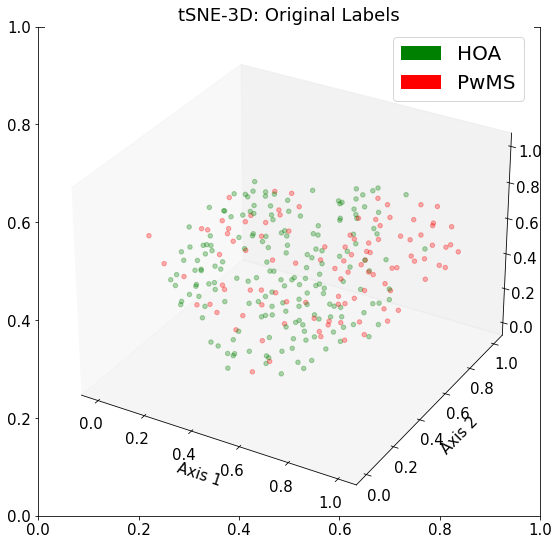

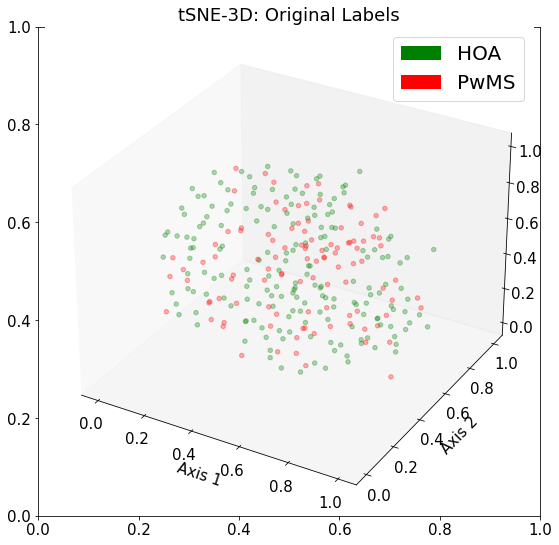

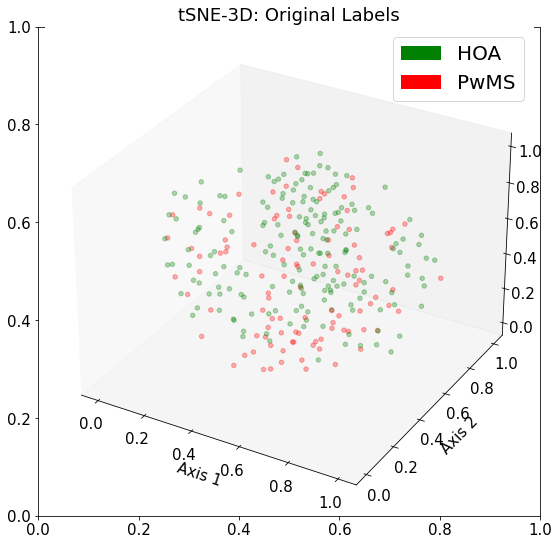

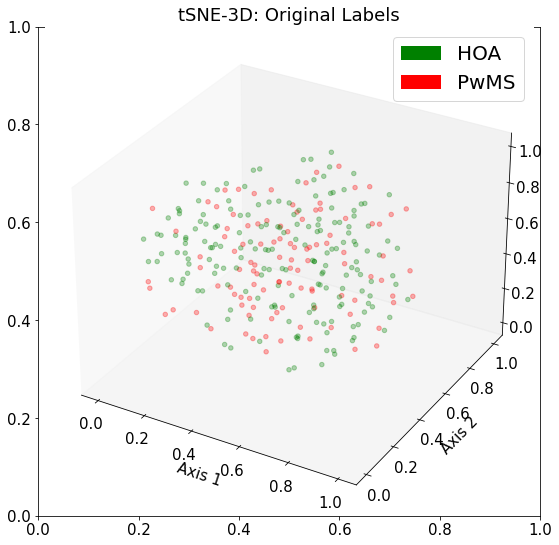

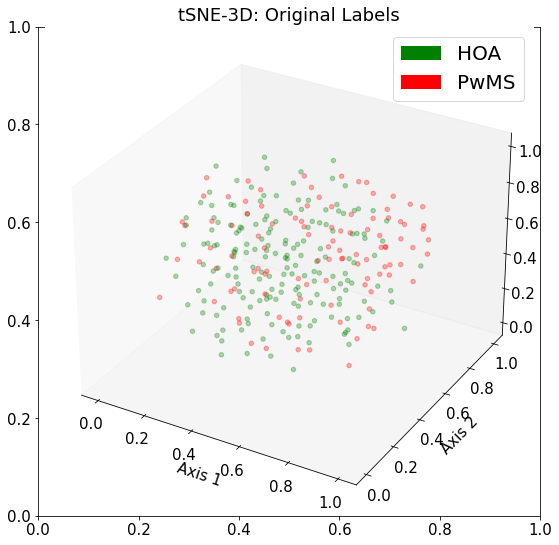

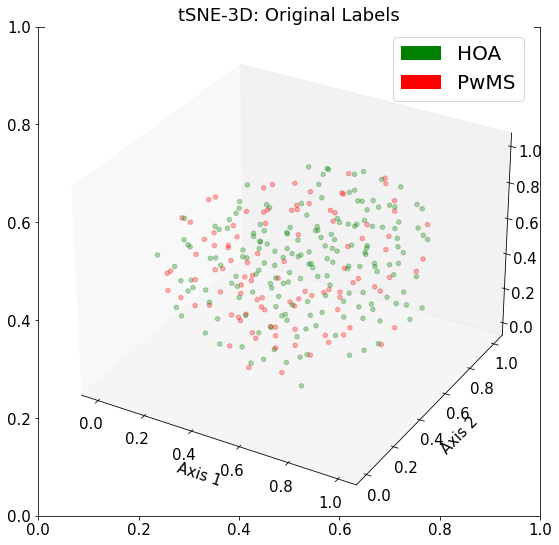

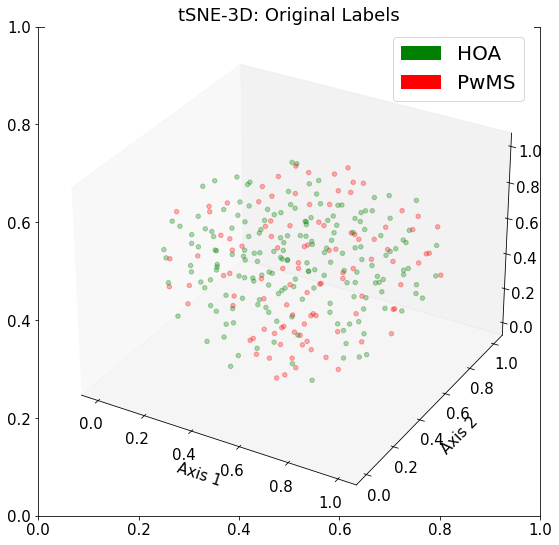

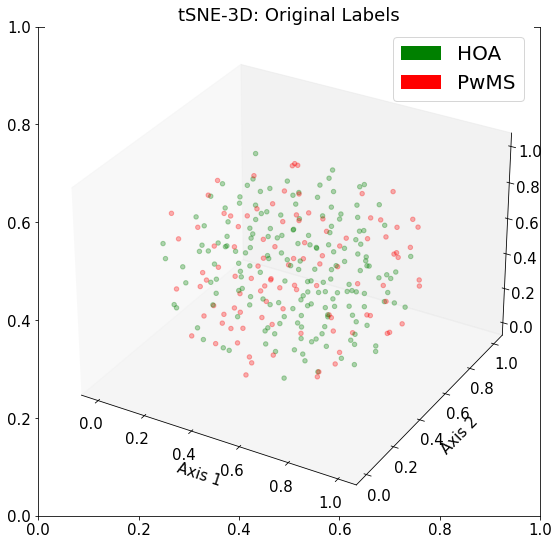

In [121]:
for p in [30, 40, 50, 60, 70, 80, 90, 100]:
    tsne3D(p)

### Fold 5

In [122]:
#Loading the fold 1 pretrained model
skorch_model.initialize() # This is important!
skorch_model.load_params(f_params = path + fold5_model_path)  

#Loading the fold 1 training and test data
fold_to_analyse = 5
train_X, train_Y, test_X, test_Y = load_train_test_X_Y_per_fold(fold_to_analyse)

#Keeping a separate column for the PIDs
train_Y.reset_index(inplace= True)
train_Y.columns = ['PID', 'Label']

test_Y.reset_index(inplace= True)
test_Y.columns = ['PID', 'Label']

setting random seed to:  0
Re-initializing optimizer.


In [123]:
#Processing the read train/test X to 3D tensor of batch_size*time_steps(5)*features(21)
train_X_, test_X_ = [], []

for idx in range(len(train_X)):
    new_data_sample = torch.tensor(train_X.iloc[idx].apply(lambda x : [float(x) for x in x.replace("tensor(", "").replace(")", "").replace("[", "").replace ("]", "").split(",")])).reshape((5, 21))
    train_X_.append(new_data_sample)

for idx in range(len(test_X)):
    new_data_sample = torch.tensor(test_X.iloc[idx].apply(lambda x : [float(x) for x in x.replace("tensor(", "").replace(")", "").replace("[", "").replace ("]", "").split(",")])).reshape((5, 21))
    test_X_.append(new_data_sample)
    
print ('No. of samples in training set for fold', fold_to_analyse, ':', len(train_X_))
print ('No. of samples in testing set for fold', fold_to_analyse, ':', len(test_X_))

#Converting list of tensors to 3D tensor 
train_X_ = torch.stack(train_X_)
test_X_ = torch.stack(test_X_)

print (train_X_.shape, test_X_.shape)

No. of samples in training set for fold 5 : 1150
No. of samples in testing set for fold 5 : 286
torch.Size([1150, 5, 21]) torch.Size([286, 5, 21])


In [130]:
#last layer features for the train set of this fold
skorch_model.module_.forward(train_X_)
last_layer_features_train = skorch_model.module_.lastLayerFeatures
print ('Last layer features for training:', last_layer_features_train.shape)

#Last layer features for the test set of this fold 
skorch_model.module_.forward(test_X_)
last_layer_features_test = skorch_model.module_.lastLayerFeatures
print ('Last layer features for testing:',last_layer_features_test.shape)

Last layer features for training: torch.Size([1150, 2048])
Last layer features for testing: torch.Size([286, 2048])


In [131]:
last_layer_features_train = last_layer_features_train.detach().numpy()
last_layer_features_test = last_layer_features_test.detach().numpy()

train_df = pd.DataFrame(last_layer_features_train)
train_df = pd.concat((train_df, train_Y), axis = 1) #Appending PID and label
train_df['marker'] = 'train' #To mark these data as training set data 

test_df = pd.DataFrame(last_layer_features_test)
test_df = pd.concat((test_df, test_Y), axis = 1) #Appending PID and label
test_df['marker'] = 'test' #To mark these data as testing set data 

#Combining all data last layer features, PID, label along with marker for train/test data
df = pd.concat((train_df, test_df), ignore_index=True)
df['color'] = 'r' #Initially all red
df['color'][df[df['Label']==0].index] = 'g' #Green for controls 

In [132]:
#For only test features 
df = test_df
df['color'] = 'r' #Initially all red
df['color'][df[df['Label']==0].index] = 'g' #Green for controls 

In [134]:
last_layer_features = df[list(range(last_layer_features_test.shape[1]))]
print ((last_layer_features<0).sum().sum())
data_to_reduce = last_layer_features
print ('Dimesions for original last layer test set features: ', data_to_reduce.shape)
data_to_reduce_normalized = StandardScaler().fit_transform(data_to_reduce)

normalize = False #Not normalizing last layer features before feeding to t-SNE 
test = True

0
Dimesions for original last layer test set features:  (286, 2048)


In [135]:
def tsne_plot(perp = 30):
    # #Linear methods: NMF/PCA/ICA
    # # NMF
    # model_NMF = decomposition.NMF(n_components=2, init='nndsvda', max_iter=500)
    # NMF_2D = model_NMF.fit_transform(data_to_reduce)
    # df = pd.concat((df, pd.DataFrame(NMF_2D, columns = ['NMF_2D_X', 'NMF_2D_Y'])), axis = 1)

    # model_NMF3 = decomposition.NMF(n_components=3, init='nndsvda', max_iter=200)
    # NMF_3D = model_NMF3.fit_transform(data_to_reduce)
    # df = pd.concat((df, pd.DataFrame(NMF_3D, columns = ['NMF_3D_X', 'NMF_3D_Y', 'NMF_3D_Z'])), axis = 1)

    # # PCA
    # model_pca = decomposition.PCA(n_components=2)
    # PCA_2D = model_pca.fit_transform(data_to_reduce)
    # df = pd.concat((df, pd.DataFrame(NMF_2D, columns = ['NMF_2D_X', 'NMF_2D_Y'])), axis = 1)

    # model_pca = decomposition.PCA(n_components=3)
    # PCA_3D = model_pca.fit_transform(data_to_reduce)
    # df = pd.concat((df, pd.DataFrame(NMF_3D, columns = ['NMF_3D_X', 'NMF_3D_Y', 'NMF_3D_Z'])), axis = 1)

    # # ICA
    # model_ICA = decomposition.FastICA(n_components=2)
    # ICA_2D = model_ICA.fit_transform(data_to_reduce)
    # model_ICA = decomposition.FastICA(n_components=3)
    # ICA_3D = model_ICA.fit_transform(data_to_reduce)

    #Non linear methods: t-SNE
    #t-SNE 
    tsne = manifold.TSNE(n_components=2, init='random', random_state=0, perplexity=perp, n_iter = 20000) #2D tsne 

    if normalize:
        tsne_2D = tsne.fit_transform(data_to_reduce_normalized)
    else:
        tsne_2D = tsne.fit_transform(data_to_reduce)

    #Normalizing the t-SNE values after computation 
    tsne_2D_normalized = np.concatenate((min_max_scale(tsne_2D[:, 0]), min_max_scale(tsne_2D[:, 1])), axis = 1)

    #However, if you use the same data and perplexity, you can compare the 
    #Kullback-Leibler divergences that t-SNE reports. It is perfectly fine to 
    #run t-SNE ten times, and select the solution with the lowest KL divergence.
    print ('KL divergence for t-SNE 2D = ', tsne.kl_divergence_, 'with perplexity = ', perp)


    # tsne = manifold.TSNE(n_components=3, init='random', random_state=0, perplexity=30) #3D tsne 
    # tsne_3D = tsne.fit_transform(data_to_reduce)
    
    #2D t-SNE Scatter plot 
    f = plt.figure(figsize=(9, 9))
    ax = f.add_subplot(1, 1, 1)
    ax.scatter(tsne_2D_normalized[:, 0], tsne_2D_normalized[:, 1], c = df['color'], alpha =0.3)
    p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc='green')
    # p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc='cyan')
    p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc='blue')
    p4 = plt.Rectangle((0, 0), 0.1, 0.1, fc='red')
    ax.legend((p1, p4), ('HOA','PwMS'), loc='best', fontsize = 20);
    ax.grid(False)
    ax.set_xlabel('Axis 1')
    ax.set_ylabel('Axis 2')
    ax.set_title("tsne_2D: Original Labels")
    plt.savefig('D:\\gait\\results\\SubjectGen_LowDimViz\\fold' + str(fold_to_analyse) + '\\tsne_2D_original_' + str(perp) + str(normalize) + 'test_' + str(test) + '.png',dpi = 200)
    plt.close()
    
    tsne2D_added_colors = pd.DataFrame(tsne_2D_normalized, df['color'])
    tsne2D_added_colors.columns = ['tsnex', 'tsney']
    x_green = tsne2D_added_colors.loc[tsne2D_added_colors.index=='g']['tsnex'].values
    y_green = tsne2D_added_colors.loc[tsne2D_added_colors.index=='g']['tsney'].values
    x_red =tsne2D_added_colors.loc[tsne2D_added_colors.index=='r']['tsnex'].values
    y_red = tsne2D_added_colors.loc[tsne2D_added_colors.index=='r']['tsney'].values

    #2D t-SNE scatter plot with joint and marginal distributions 
    ###Plotting with the distributions
    mpl.rcParams['axes.spines.top'] = True
    mpl.rcParams['axes.spines.right'] = True
    plt.rcParams['font.size'] = 15
    a = 0.2
    zo=0
    l=12
    p = sns.JointGrid(x = x_red, y = y_red, size = 7)
    p.x = list( x_red)
    p.y = list( y_red)
    p.plot_joint(plt.scatter, c="r", alpha = a)
    p.plot_marginals(sns.distplot, color='r', axlabel=[])
    p.plot_joint(sns.kdeplot, zorder=zo, n_levels=l, cmap="Reds")
#     plt.grid()
    p.x = list( x_green)
    p.y = list( y_green)
    p.plot_joint(plt.scatter, c="g", alpha = a)
    p.plot_marginals(sns.distplot, color='g', axlabel=[])
    p.plot_joint(sns.kdeplot, zorder=zo, n_levels=l, cmap="Greens")
#     plt.grid()
    p.set_axis_labels(xlabel='t-SNE Dimension 1', ylabel='t-SNE Dimension 2')
    # p.ax_joint.set_xticklabels([])
    # p.ax_joint.set_yticklabels([])
    # p.ax_marg_x.legend_.remove()
    p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc= 'green')
    # p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc='blue')
    p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc='red')
    plt.legend((p1,p3), ('HOA','PwMS'), loc='best', fontsize = 15)
    # plt.legend((p1, p2, p3), ('Low', 'Medium', 'High'), loc='best',prop={'size':12});
    # plt.title('Trial W', fontsize = 14)
    plt.xlabel('x-axis', fontsize = 15)
    plt.ylabel('y-axis', fontsize = 15)
#     plt.grid(linestyle='--')
    plt.tight_layout()
    plt.savefig('D:\\gait\\results\\SubjectGen_LowDimViz\\fold' + str(fold_to_analyse) + '\\tsne_2D_original_distributions_' + str(perp) + str(normalize)+ 'test_' + str(test) + '.png', dpi = 300)


KL divergence for t-SNE 2D =  0.24312885105609894 with perplexity =  30


KeyboardInterrupt: 

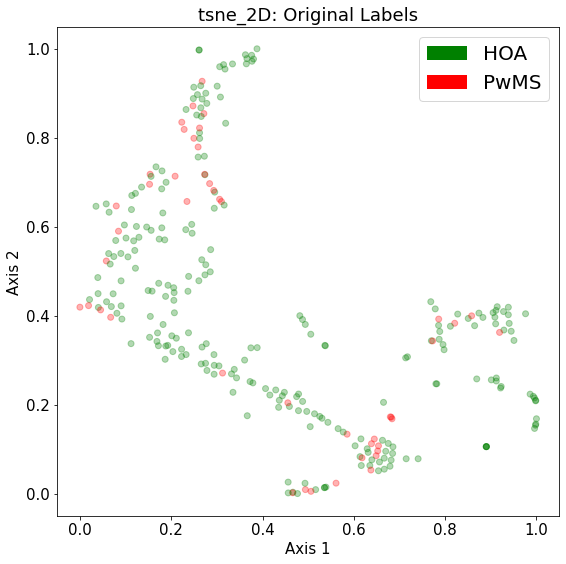

In [136]:
for p in [30, 50, 70, 100]:
    tsne_plot(p)

### 3D t-SNE

In [137]:
#3D t-SNE 
#Non linear methods: t-SNE
#t-SNE 
def tsne3D(perp = 30):
    tsne = manifold.TSNE(n_components=3, init='random', random_state=0, perplexity=perp, n_iter = 20000) #2D tsne 
    tsne_3D = tsne.fit_transform(data_to_reduce)

    #Normalizing the t-SNE values after computation 
    tsne_3D_normalized = np.concatenate((min_max_scale(tsne_3D[:, 0]), min_max_scale(tsne_3D[:, 1]), min_max_scale(tsne_3D[:, 2])), axis = 1)

    #However, if you use the same data and perplexity, you can compare the 
    #Kullback-Leibler divergences that t-SNE reports. It is perfectly fine to 
    #run t-SNE ten times, and select the solution with the lowest KL divergence.
    print ('KL divergence for t-SNE 3D = ', tsne.kl_divergence_, 'with perplexity = ', perp)

    f = plt.figure(figsize=(9, 9))
    ax = f.add_subplot(1, 1, 1)
    ax = plt.axes(projection='3d')
    ax.scatter3D(tsne_3D_normalized[:, 0], tsne_3D_normalized[:, 1], tsne_3D_normalized[:, 2], c = df['color'], alpha =0.3)
    p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc='green')
    # p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc='cyan')
    # p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc='blue')
    p4 = plt.Rectangle((0, 0), 0.1, 0.1, fc='red')
    ax.legend((p1, p4), ('HOA','PwMS'), loc='best', fontsize = 20);
    ax.grid(False)
    ax.set_xlabel('Axis 1')
    ax.set_ylabel('Axis 2')
    ax.set_title("tSNE-3D: Original Labels")
    plt.savefig('D:\\gait\\results\\SubjectGen_LowDimViz\\fold' + str(fold_to_analyse) + '\\tsne3D_original_perp'+str(perp)+ 'test_' + str(test) +'.png',dpi = 200)

KL divergence for t-SNE 3D =  0.6042967438697815 with perplexity =  30
KL divergence for t-SNE 3D =  0.8946937918663025 with perplexity =  40
KL divergence for t-SNE 3D =  0.8881276249885559 with perplexity =  50
KL divergence for t-SNE 3D =  0.9326661229133606 with perplexity =  60
KL divergence for t-SNE 3D =  1.1240776777267456 with perplexity =  70
KL divergence for t-SNE 3D =  1.2082306146621704 with perplexity =  80
KL divergence for t-SNE 3D =  1.4127594232559204 with perplexity =  90
KL divergence for t-SNE 3D =  1.6194067001342773 with perplexity =  100


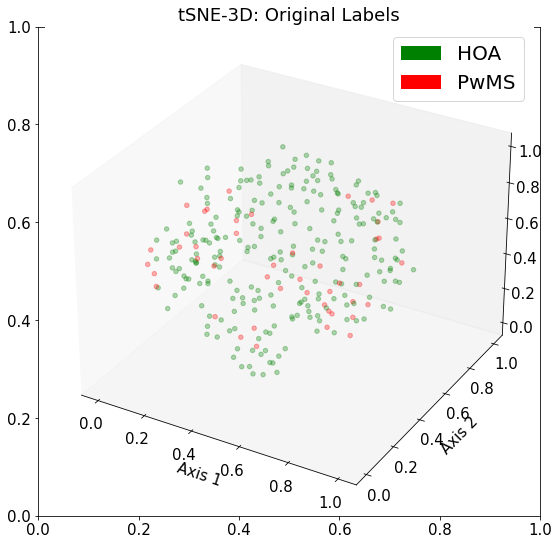

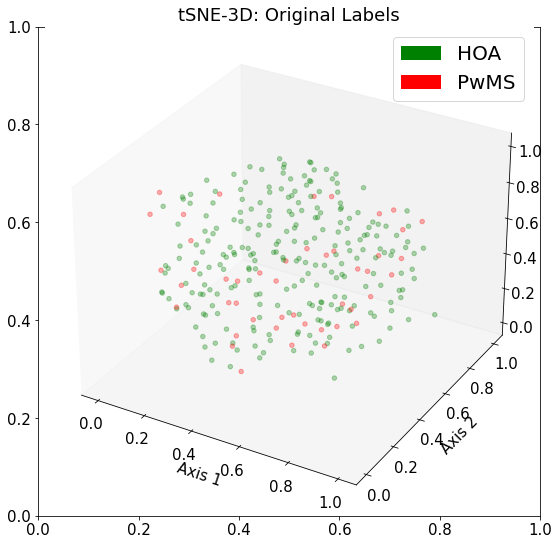

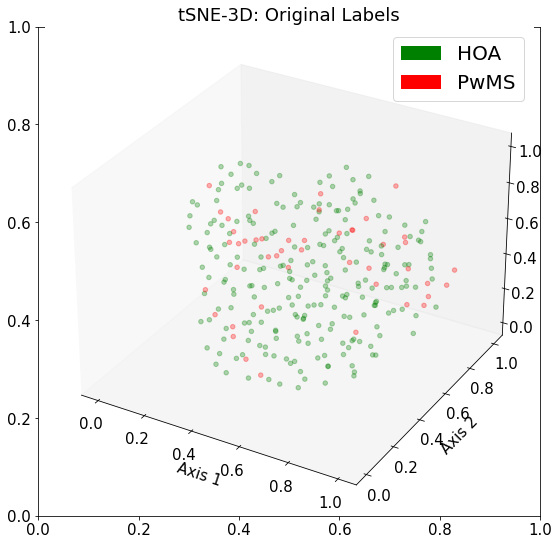

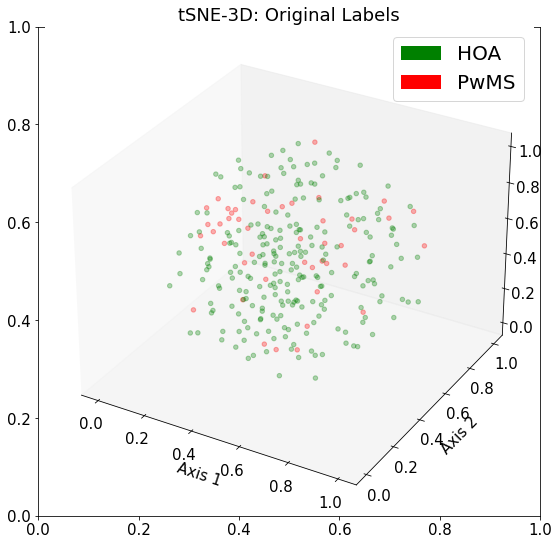

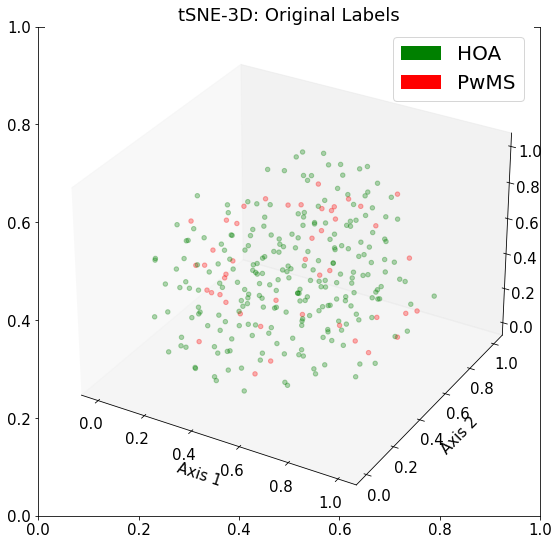

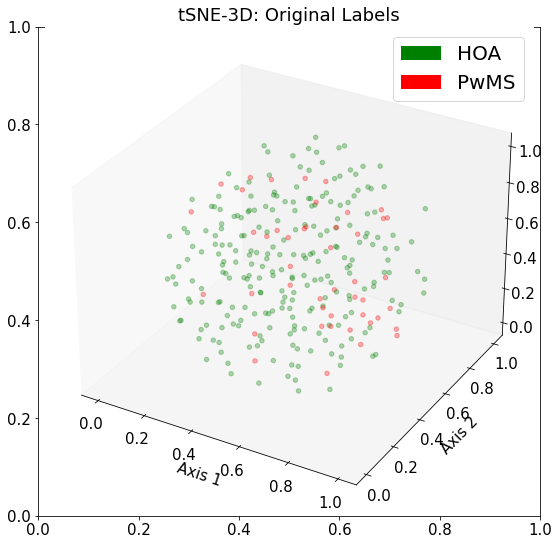

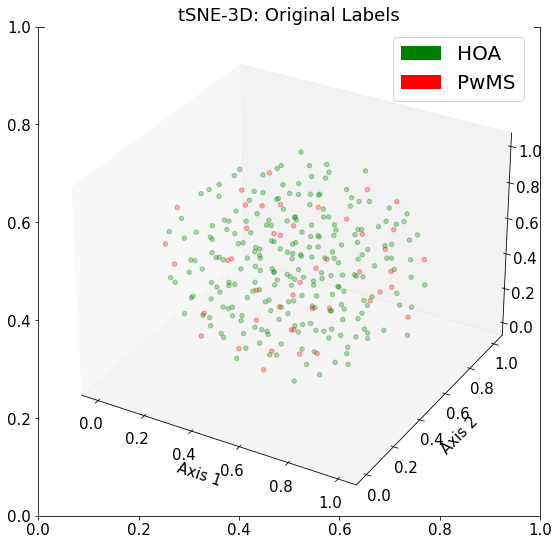

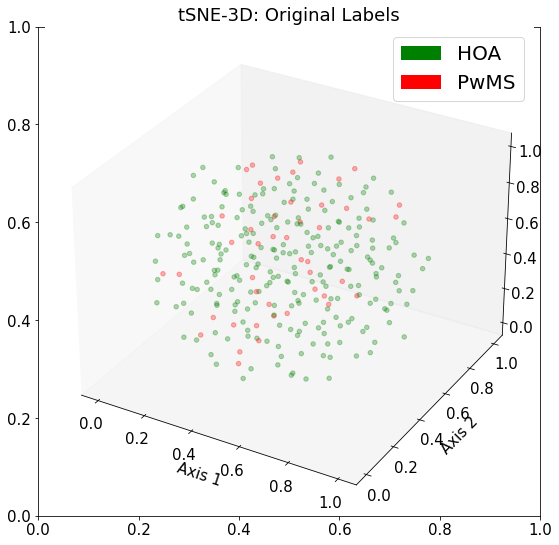

In [138]:
for p in [30, 40, 50, 60, 70, 80, 90, 100]:
    tsne3D(p)